In [1]:
import tensorflow as tf
import os, shutil
from tensorflow.keras.backend import set_session

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="0" 


config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True # allocate dynamically
set_session(tf.Session(config=config))

from tensorflow.keras.layers import (
        Input,
        InputLayer,
        Flatten,
        Activation,
        Dense,
        Convolution2D,
        Conv2DTranspose,
        MaxPooling2D)

from tensorflow.keras.activations import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import (
    to_categorical,
    multi_gpu_model)
from tensorflow.keras import backend as K 
from tensorflow.keras import initializers

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

/home/vinh/.conda/envs/keras/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/vinh/.conda/envs/keras/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


We will show saliency map/backpropagation heatmaps obtained with feature extraction layers of VGG16.

In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input

VGG16_net = VGG16(weights='imagenet')

In [3]:
print (VGG16_net.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [18]:
from tensorflow.keras.preprocessing import image
img = image.load_img('elephant.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)


In [19]:
preds = VGG16_net.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.9094213), ('n01871265', 'tusker', 0.08618258), ('n02504013', 'Indian_elephant', 0.004354576)]


In [28]:
def extract_layer_value(network, numb_hidden_layer):
    predicts = []
    for i in range(1, numb_hidden_layer+1, 1):
        print (network.layers[i].name)
        output = network.layers[i].output
        predict = K.function([network.input], [output])
        predicts.append(predict)
    
    return predicts

extractor = extract_layer_value(VGG16_net, 22)

block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
flatten
fc1
fc2
predictions


In [36]:
def get_input_images(img_name_list):
    input_data = []
    for img_name in img_name_list:
        img = image.load_img(img_name, target_size=(224, 224))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        input_data.append(x)
    input_data = np.stack(input_data, axis=0)
    return input_data

img_name_list = ['electric_guitar.jpg', 'hummingbird.jpg', 'stingray.jpg', 'lion.jpg', 'cat.jpg']
input_data = get_input_images(img_name_list)

pool_data = []
for i in range(22):
    pool_data.append(extractor[i]([input_data])[0])

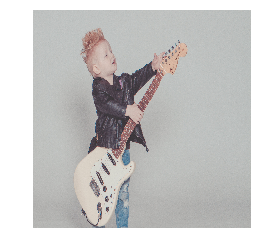

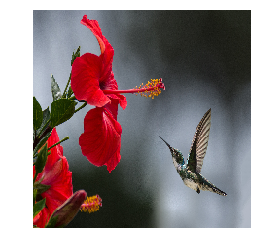

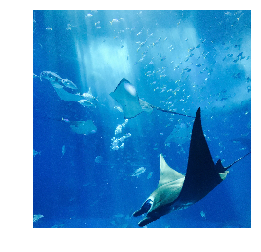

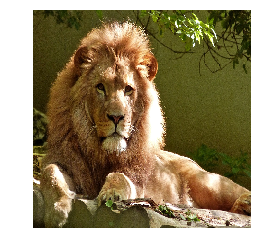

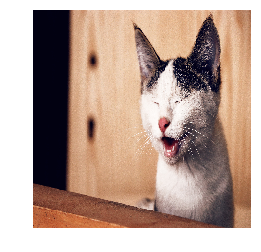

In [54]:
def plot_input_images(img_name_list):
    for img_name in img_name_list:
        img = image.load_img(img_name, target_size=(224, 224))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
def get_cropped_original_input_images(img_name_list):
    input_data = []
    for img_name in img_name_list:
        img = image.load_img(img_name, target_size=(224, 224))
        input_data.append(img)
    return input_data

plot_input_images(img_name_list)

# Plot the feature map at each pooling layer of VGG16 net

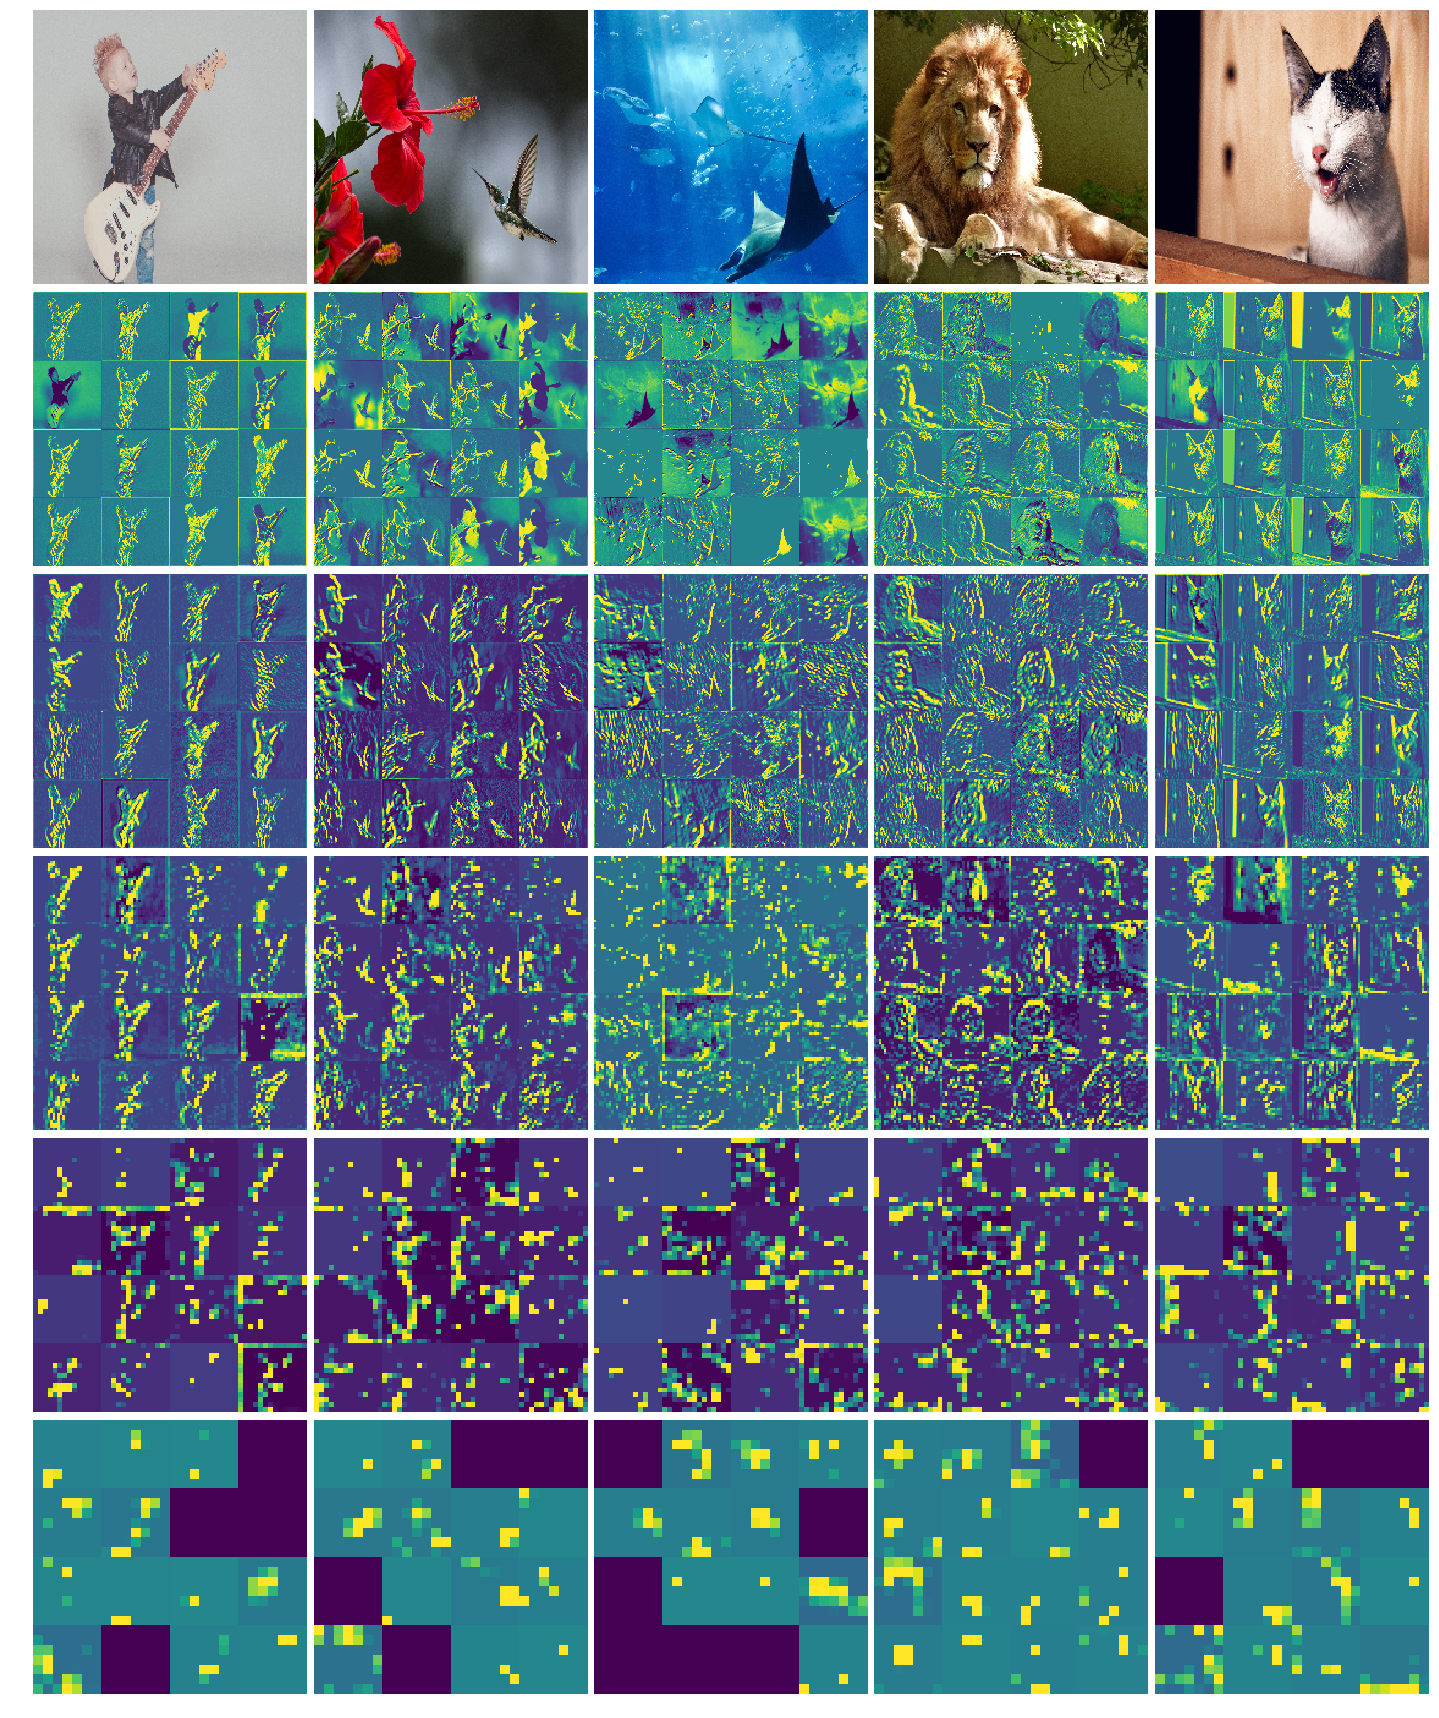

In [60]:
import matplotlib.gridspec as gridspec


def get_feature_map(layer_names, pool_data, data_idx):
    
    images_per_row = 4
    display_grids = []
    for layer_name, layer_activation in zip(layer_names, pool_data):
        
        if (layer_name not in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']):
            continue
        
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = 4
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[data_idx,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                            row * size : (row + 1) * size] = channel_image
        
        '''
        scale = 2. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                           scale * display_grid.shape[0]))
        #plt.title(layer_name)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        '''
        display_grids.append(display_grid)
        
    return display_grids
        
    
def plot_feature_map(pool_data, original_input_data, data_idx):
    layer_names = ['block1_conv1', 'block1_conv2', 'block1_pool',
                  'block2_conv1', 'block2_conv2', 'block2_pool',
                  'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool',
                  'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool',
                  'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']
    fig = plt.figure(figsize=(25, 31))
    gs = gridspec.GridSpec(6, 5)
    gs.update(wspace=0.025, hspace=0.025)
    for idx in data_idx:
        display_grids = get_feature_map(layer_names, pool_data, data_idx = idx)
        ax = fig.add_subplot(gs[0, idx])
        ax.imshow(original_input_data[idx])
        ax.axis('off')
        
        for row_idx, display_grid in enumerate(display_grids):
            ax = fig.add_subplot(gs[row_idx+1, idx])
            ax.imshow(display_grid)
            ax.axis('off')
            
    plt.show()

origin_data = get_cropped_original_input_images(img_name_list)
plot_feature_map(pool_data, origin_data, [i for i in range(5)])
        

# Class Saliency Map

In [124]:
print (VGG16_net.output[:,999])

Tensor("strided_slice_254:0", shape=(?,), dtype=float32)


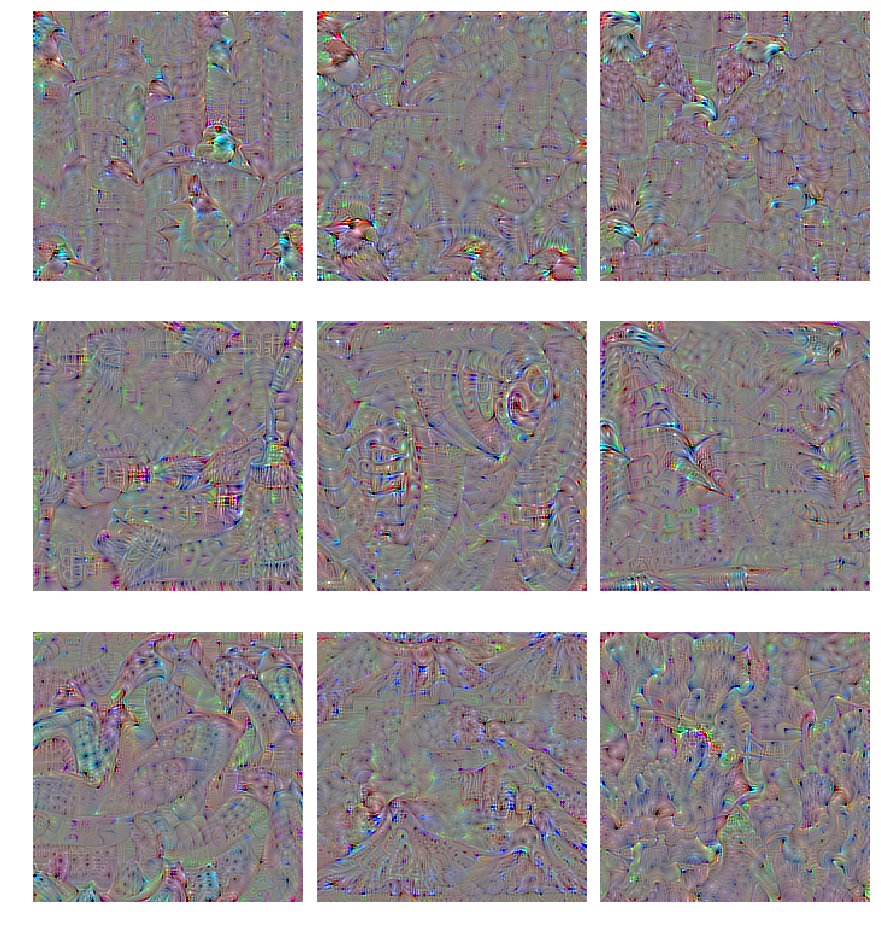

In [133]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def saliencymap_output(model, output_idx):
    loss = model.output.op.inputs[0][:, output_idx]
    #loss = model.output[:, output_idx]
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.zeros((1, 224, 224, 3)) 
    
    step = 1.
    for i in range(300):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    input_img_data[:, :, :, 0] += 103.939
    input_img_data[:, :, :, 1] += 116.779
    input_img_data[:, :, :, 2] += 123.68
    
    '''
    input_img_data[:, :, :, 0] += 123.68
    input_img_data[:, :, :, 1] += 116.779
    input_img_data[:, :, :, 2] += 103.939

    '''
    '''
    
    input_img_data[:, :, :, 0] -= 103.939
    input_img_data[:, :, :, 1] -= 116.779
    input_img_data[:, :, :, 2] -= 123.68
    '''
    
    '''
    input_img_data[:, :, :, 0] -= 123.68
    input_img_data[:, :, :, 1] -= 116.779
    input_img_data[:, :, :, 2] -= 103.939
    '''
    img = input_img_data[0]
    return deprocess_image(img)

img = saliencymap_output(VGG16_net, output_idx=9)

def plot_saliencymap_output(model, data_idx):
    fig = plt.figure(figsize=(15, 17))
    gs = gridspec.GridSpec(3, 3)
    gs.update(wspace=0.05, hspace=0.025)
    for gs_idx, output_idx in enumerate(data_idx):
        img = saliencymap_output(model, output_idx)
        ax = fig.add_subplot(gs[gs_idx//3, gs_idx%3])
        ax.imshow(img)
        ax.axis('off')
                    
    plt.show()

plot_saliencymap_output(VGG16_net, [11, 18, 22, 462, 479, 563, 954, 980, 991])

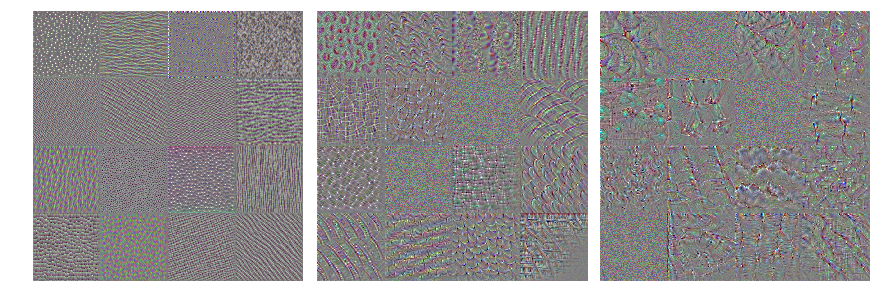

In [120]:
def saliencymap_featuremap(model, layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

def plot_filters(model, layer_name):

    images_per_row = 4
    layer_output_shape = model.get_layer(layer_name).output_shape
    n_features = layer_output_shape[-1]
    size = 150
    ncols = 4
    display_grid = np.zeros((size * ncols, images_per_row * size, 3), np.uint8)

    for col in range(ncols):  # iterate over the rows of our results grid
        for row in range(images_per_row):  # iterate over the columns of our results grid
            filter_img = saliencymap_featuremap(model, layer_name, col * images_per_row + row)
            display_grid[col * size : (col + 1) * size,
                        row * size : (row + 1) * size] = filter_img
    return display_grid

def plot_saliencymap_featuremap(model, layer_names):
    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 3)
    gs.update(wspace=0.05, hspace=0.025)
    for gs_idx, layer_name in enumerate(layer_names):
        img = plot_filters(model, layer_name)
        ax = fig.add_subplot(gs[0, gs_idx])
        ax.imshow(img)
        ax.axis('off')
                    
    plt.show()

plot_saliencymap_featuremap(VGG16_net, ['block3_conv1', 'block4_conv1', 'block5_conv1'])


# Backpropation, DeconvNet, GuidedBackprop

In [2]:
'''
NOTE: the model we are dealing with has model.layers[0] = model.input,
hence, we have to start with layer_idx = 1
'''
from keras.utils.vis_utils import model_to_dot

class ReconstructionMethod():
    def __init__ (self, model, layer_name, input_data, layer_idx = None, masking=None):
        self.model = model
        self.layer_name = layer_name
        self.layer = model.get_layer(layer_name)
        self.input_data = input_data
        
        if (layer_idx is None):
            for i, layer in enumerate(self.model.layers):
                if (layer.name == self.layer_name):
                    self.layer_idx = i
                    break
                    
        if (masking is None):
            shape = [1] + list(self.layer.output_shape[1:])
            masking = np.ones(shape, 'float32')
        self.masking = masking
        self.dependency_dict = self.model2dict(model)
    
    def model2dict(self, model):
        graph = model_to_dot(model)

        node_obj_list = [node.obj_dict for node in graph.get_node_list()[1:]]
        node_obj2name = {node['name']:node['attributes']['label'].split(':')[0] for node in node_obj_list}

        last_node_obj = node_obj_list[-1]['name']
        edge_obj_list = graph.get_edge_list()
        edge_obj2obj = {last_node_obj:[]}

        for edge in edge_obj_list:
            source = edge.get_source(); destination = edge.get_destination()
            if (source not in edge_obj2obj.keys()):
                edge_obj2obj[source] = [destination]
            else:
                edge_obj2obj[source].append(destination)

        dependency_dict = {}
        for node_obj, node_name in node_obj2name.items():
            if (node_obj == last_node_obj):
                dependency_dict[node_name] = []
                continue

            destination_node_obj_list = edge_obj2obj[node_obj]
            destination_node_name_list = [node_obj2name[node] for node in destination_node_obj_list]
            dependency_dict[node_name] = destination_node_name_list

        return dependency_dict

    def filter_gradient(self, x):
        x_abs = np.abs(x)
        x_max = np.amax(x_abs, axis=-1)
        return x_max
    
    def back_propagation(self):
        loss = K.mean(self.layer.output * self.masking)
        gradients = K.gradients(loss, self.model.input)[0]
        func = K.function([self.model.input], [gradients])
        output_data = func([self.input_data])[0] 
        output_data = self.filter_gradient(output_data)
        return (output_data, func)
        
    def smooth_grad(self, iteration = 50):

        _, func = self.back_propagation()
        
        shape = [iteration] + list(self.model.input.shape[1:])
        random_noise = np.random.random(shape)
        new_images = random_noise + self.input_data
        new_gradients = func([new_images])[0]
        smooth_gradients = np.expand_dims(np.mean(new_gradients, axis=0), axis=0)
        smooth_gradients = self.filter_gradient(smooth_gradients)
        return smooth_gradients
    
    def feed_forward(self):
        forward_layers = [layer.output for layer in self.model.layers[1:self.layer_idx+1]]
        func = K.function([self.model.input], forward_layers)
        self.forward_values = func([self.input_data])
    
        return self.forward_values    
        
    def guided_backprop_adjacent(self, layer_cur, layer_prev, values_prev, gate_b):
        loss = K.mean(layer_cur * gate_b)
        gradients = K.gradients(loss, layer_prev)[0]
        gate_f = K.cast(values_prev > 0., 'float32')
        guided_gradients = gradients * gate_f
        
        func = K.function([self.model.input], [guided_gradients])
        output_data = func([self.input_data])[0]
        return output_data
        
        
    def guided_backpropagation(self):
        forward_values = [self.input_data] + self.feed_forward()
        forward_values_dict = {self.model.layers[i].name:forward_values[i] for i in range(self.layer_idx+1)}
        last_layer_name = self.model.layers[self.layer_idx].name
        calculated_gradients = {last_layer_name: self.masking}
        
        for layer_idx in range(self.layer_idx-1, -1, -1):
            layer_prev = self.model.layers[layer_idx].output
            layer_prev_name = self.model.layers[layer_idx].name
            layer_cur_names = self.dependency_dict[layer_prev_name] 
            for layer_cur_name in layer_cur_names:
                layer_cur = self.model.get_layer(layer_cur_name).output
                gradients_cur = calculated_gradients[layer_cur_name]
                gate_b = (gradients_cur > 0.) * gradients_cur
                gradients = self.guided_backprop_adjacent(layer_cur,
                                                         layer_prev,
                                                         forward_values_dict[layer_prev_name],
                                                         gate_b)
                    
                if (layer_prev not in calculated_gradients.keys()):
                    calculated_gradients[layer_prev_name] = gradients
                else:
                    calculated_gradients[layer_prev_name] += gradients
                
            gradients = calculated_gradients[layer_prev_name]
            if (gradients.min() != gradients.max()):
                gradients = self.deconv_process(gradients)
                calculated_gradients[layer_prev_name] = gradients

            
        gradients_input = calculated_gradients[self.model.layers[0].name]
        gradients_input = self.filter_gradient(gradients_input)
        gradients_input = self.deprocess_image(gradients_input)
        return gradients_input  
    
    def deconvnet(self):
        last_layer_name = self.model.layers[self.layer_idx].name
        calculated_gradients = {last_layer_name: self.masking}
        
        for layer_idx in range(self.layer_idx-1, -1, -1):
            layer_prev = self.model.layers[layer_idx].output
            layer_prev_name = self.model.layers[layer_idx].name
            layer_cur_names = self.dependency_dict[layer_prev_name] 

            forward_values_prev = np.ones([self.input_data.shape[0]] + list(self.model.layers[layer_idx].output_shape[1:])) 
            
            for layer_cur_name in layer_cur_names:
                layer_cur = self.model.get_layer(layer_cur_name).output
                gradients_cur = calculated_gradients[layer_cur_name]
                gate_b = (gradients_cur > 0.) * gradients_cur
                gradients = self.guided_backprop_adjacent(layer_cur,
                                                         layer_prev,
                                                         forward_values_prev,
                                                         gate_b)
                
                if (layer_prev not in calculated_gradients.keys()):
                    calculated_gradients[layer_prev_name] = gradients
                else:
                    calculated_gradients[layer_prev_name] += gradients
                    
            gradients = calculated_gradients[layer_prev_name]
            if (gradients.min() != gradients.max()):
                gradients = self.deconv_process(gradients)
                calculated_gradients[layer_prev_name] = gradients
            
        gradients_input = calculated_gradients[self.model.layers[0].name]
        gradients_input = self.filter_gradient(gradients_input)
        gradients_input = self.deprocess_image(gradients_input)
        return gradients_input 
        
    def normalize_pic(self, img):
        img = (img - img.min())/(img.max() - img.min() + 1e-50)
        return img

    def deprocess_image(self, x):
        # normalize tensor: center on 0., ensure std is 0.1
        x = np.array(x, np.float64)
        x -= x.mean()
        x /= (x.std() + 1e-5)
        x *= 0.1

        # clip to [0, 1]
        x += 0.5
        x = np.clip(x, 0, 1)

        # convert to RGB array
        x *= 255
        x = np.clip(x, 0, 255).astype('uint8')
        return x
    
    def deconv_process(self, img):
        '''Assume gap is always < 1.'''
        gap = img.max() - img.min()
        if (abs(gap) > 1.):
            print ('Assumption is false')
        amplitude = 1./gap
        img *= amplitude
        return img

Using TensorFlow backend.


[('n03272010', 'electric_guitar', 0.18760243), ('n03888257', 'parachute', 0.13207167), ('n04228054', 'ski', 0.098478004), ('n02787622', 'banjo', 0.038334724), ('n04296562', 'stage', 0.031547576)]
[('n01833805', 'hummingbird', 0.9672114), ('n02226429', 'grasshopper', 0.012465445), ('n12620546', 'hip', 0.003697719), ('n01531178', 'goldfinch', 0.0027342632), ('n02229544', 'cricket', 0.0017535335)]
[('n01491361', 'tiger_shark', 0.39836192), ('n01494475', 'hammerhead', 0.25050297), ('n10565667', 'scuba_diver', 0.13498114), ('n01484850', 'great_white_shark', 0.07242743), ('n01498041', 'stingray', 0.04468734)]
[('n02129165', 'lion', 0.9979381), ('n02487347', 'macaque', 0.00100166), ('n02112137', 'chow', 0.00024925967), ('n02115913', 'dhole', 0.00015272798), ('n02483362', 'gibbon', 7.284601e-05)]
[('n02971356', 'carton', 0.10678859), ('n02124075', 'Egyptian_cat', 0.05317041), ('n02110806', 'basenji', 0.049907837), ('n02096585', 'Boston_bull', 0.047164492), ('n02109047', 'Great_Dane', 0.0429726

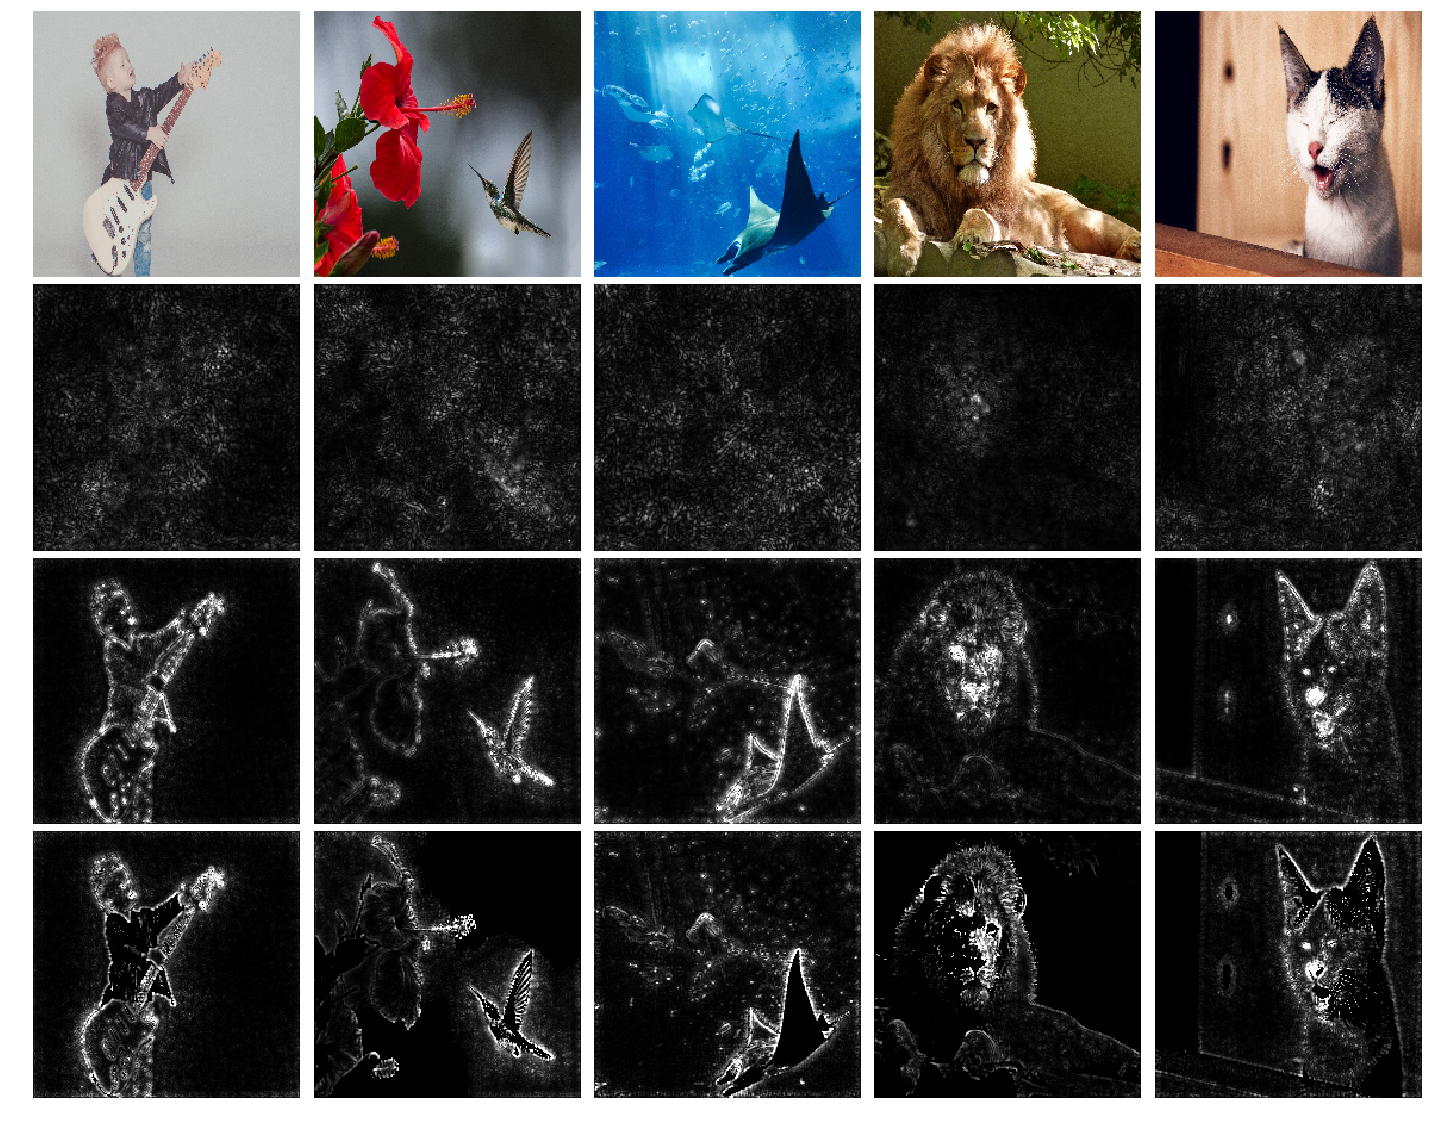

In [182]:
def plot_gradients_family(model, input_data, origin_data):
    numb_images = 5
    fig = plt.figure(figsize=(25, 20))
    gs = gridspec.GridSpec(4, 5)
    gs.update(wspace=0.025, hspace=0.025)

    for idx in range(numb_images):
        ax = fig.add_subplot(gs[0, idx])
        ax.imshow(origin_data[idx]); ax.axis('off')
        
        preds = model.predict(input_data[idx:idx+1])
        reconstruct = ReconstructionMethod(VGG16_net, 'predictions', input_data[idx:idx+1])
        masking = np.zeros(preds.shape); masking[0, np.argmax(preds)] = 1.
        print (decode_predictions(preds, top=5)[0])
        
        backprop, _ = reconstruct.back_propagation()
        ax = fig.add_subplot(gs[1, idx])
        ax.imshow(backprop[0], cmap='gray'); ax.axis('off')

        deconv_output = reconstruct.deconvnet()
        ax = fig.add_subplot(gs[2, idx])
        ax.imshow(deconv_output[0], cmap='gray'); ax.axis('off')

        guided_output = reconstruct.guided_backpropagation()
        ax = fig.add_subplot(gs[3, idx])
        ax.imshow(guided_output[0], cmap='gray'); ax.axis('off')

    plt.show()
        
plot_gradients_family(VGG16_net, input_data, origin_data)

# MIM, Guided-Activation and Guided-MIM on the digit pair 6-9 of MNIST

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [4]:
def get_digit_pair(digit_pair, images, labels):
    groundtruth = np.argmax(labels, axis=-1)
    selected_idx = (digit_pair[0] == groundtruth)
    new_images = images[selected_idx]
    new_labels = np.zeros(new_images.shape[0])
    
    selected_idx = (digit_pair[1] == groundtruth)
    new_images = np.concatenate((new_images, images[selected_idx]), axis=0)
    new_labels = np.concatenate((new_labels, np.ones(images[selected_idx].shape[0])), axis=0)

    #random_idx = np.random.permutation(new_images.shape[0])
    #return new_images[random_idx], new_labels[random_idx]
    return new_images, new_labels
    
def get_digit_tuple(digit_list, images, labels):
    groundtruth = np.argmax(labels, axis=-1)
    selected_idx = (digit_pair[0] == groundtruth)
    new_images = None
    for digit_idx, digit in enumerate(digit_list):
        selected_idx = (digit == groundtruth)
        temp_labels = np.zeros((labels[selected_idx].shape[0], len(digit_list)))
        temp_labels[:, digit_idx] = 1
        if (new_images is None):
            new_images = images[selected_idx]
            new_labels = temp_labels
        else:
            new_images = np.concatenate((new_images, images[selected_idx]), axis=0)
            new_labels = np.concatenate((new_labels, temp_labels), axis=0)
            
    #random_idx = np.random.permutation(new_images.shape[0])
    #return new_images[random_idx], new_labels[random_idx]
    return new_images, new_labels
    
train_images, train_labels = get_digit_pair([6, 9], train_images, train_labels)
test_images, test_labels = get_digit_pair([6, 9], test_images, test_labels)

In [42]:
print (np.count_nonzero(test_labels==1))

1009


In [5]:
from tensorflow.keras import optimizers 
K.clear_session()

convnet = Sequential()
convnet.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'))
convnet.add(MaxPooling2D((2, 2)))
convnet.add(Convolution2D(64, (3, 3), activation='relu', padding='same'))
convnet.add(MaxPooling2D((2, 2)))
convnet.add(Convolution2D(64, (3, 3), activation='relu', padding='same'))
convnet.add(MaxPooling2D((2, 2)))

convnet.add(Flatten())
convnet.add(Dense(64, activation='relu'))
convnet.add(Dense(1, activation='sigmoid'))
   
    
#convnet = multi_gpu_model(convnet, gpus=2)
'''                   
convnet.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
'''

convnet.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
print (convnet.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
__________

In [6]:
convnet.fit(train_images, train_labels, validation_split=1./6., epochs=5, batch_size=32)
test_loss, test_acc = convnet.evaluate(test_images, test_labels)
print ('Test loss: {}|| Test accuracy: {}'.format(test_loss, test_acc))

Train on 9889 samples, validate on 1978 samples
Epoch 1/5
9889/9889 [==============================] - 5s 545us/step - loss: 0.1546 - acc: 0.9494 - val_loss: 0.0050 - val_acc: 0.9995
Epoch 2/5
9889/9889 [==============================] - 2s 169us/step - loss: 0.0070 - acc: 0.9981 - val_loss: 0.0067 - val_acc: 0.9980
Epoch 3/5
9889/9889 [==============================] - 2s 167us/step - loss: 0.0051 - acc: 0.9983 - val_loss: 0.0011 - val_acc: 0.9995
Epoch 4/5
9889/9889 [==============================] - 2s 167us/step - loss: 0.0033 - acc: 0.9992 - val_loss: 0.0026 - val_acc: 0.9990
Epoch 5/5
1967/1967 [==============================] - 0s 46us/step
Test loss: 0.0039885604777437555|| Test accuracy: 0.9984748347737672


In [7]:
from sklearn import metrics
def mim(data, labels, number, distance_metric='euclidean', typ="quadratic"):
    def alpha(dist,typ):
        if typ=="linear":
            return dist;
        elif typ=="quadratic":
            return dist**2;
        elif typ=="exponential":
            return math.exp(dist);
    inf_vec = np.zeros(data[number].size);
    poi = data[number];
    poi_label = labels[number];
    distances = metrics.pairwise_distances(data,poi.reshape(1, -1),metric=distance_metric).ravel();
    for y in range(len(data)):
        diff = data[y] - poi;
        dist = distances[y];
        if dist!=0:
            if poi_label==labels[y]:
                inf_vec+=diff*1.0/alpha(dist,typ)
            else:
                inf_vec-=diff*1.0/alpha(dist,typ)
    return inf_vec, distances

def accumulative_mim(mim_vec):
    acc_mim = np.sum(mim_vec, axis=(0,1))
    return acc_mim

def norm_mim(mim_vec):
    norm_mim = np.array([np.linalg.norm(mim_vec[..., channel]) for channel in range(mim_vec.shape[-1])])
    return norm_mim

In [21]:
class ManipulativeHiddenLayer(object):
    def get_top_percent(self, array, influence, percentage=1.):
        total_size = array.size
        nmb_in_top = int(total_size * percentage)
        
        if (nmb_in_top <= 0):
            nmb_in_top = 1
        
        influence = np.abs(influence)
        flatten_inf = influence.flatten()
        flatten_array = array.flatten()
        mask = np.zeros_like(flatten_inf)
        sorted_increasing_index = np.argsort(flatten_inf)[-nmb_in_top:]
        mask[sorted_increasing_index] = 1.0
        result = mask.reshape(array.shape)
        #result = flatten_array * mask
        #result = result.reshape(array.shape)
        return result
    
    def get_top_1unit(self, array, influence):
        total_size = array.size
        nmb_in_top = 1
        influence = np.abs(influence)
        flatten_inf = influence.flatten()
        flatten_array = array.flatten()
        mask = np.zeros_like(flatten_inf)
        sorted_increasing_index = np.argsort(flatten_inf)[-nmb_in_top:]
        mask[sorted_increasing_index] = 1.0
        result = mask.reshape(array.shape)
        return result

    def overlay_hidden(self, img, infl):
        new_img = img + infl/max(np.amax(np.abs(infl)), 0.000001)
        return new_img

    def move_top_percent(self, array, influence, percentage=1.):
        total_size = array.size
        nmb_in_top = int(total_size * percentage)

        if (nmb_in_top <= 0):
            return np.zeros_like(array)

        flatten_inf = influence.flatten()
        flatten_array = array.flatten()
        mask = np.zeros_like(flatten_inf)
        abs_inf = np.abs(flatten_inf)
        sorted_index = np.argsort(abs_inf)[-nmb_in_top:]
        mask[sorted_index] = 1.0
        result = self.overlay_hidden(flatten_array, flatten_inf)
        result = result * mask
        result = result.reshape(array.shape)

        return result

In [9]:
def get_extractors(convnet):
    layer_names = ['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2',
                  'max_pooling2d_2', 'dense']
    extractors = []
    for layer_name in layer_names:
        output = convnet.get_layer(layer_name).output
        predict = K.function([convnet.input], [output])
        extractors.append(predict)
        
    return extractors
    
def extract_all_feature(extractors, data):
    pool_data = []
    for extractor in extractors:
        layer_output = extractor([data])[0]
        pool_data.append(layer_output)
    return pool_data
    
extractors = get_extractors(convnet)
train_pool_data = extract_all_feature(extractors, train_images)

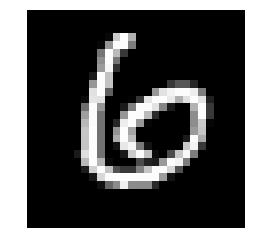

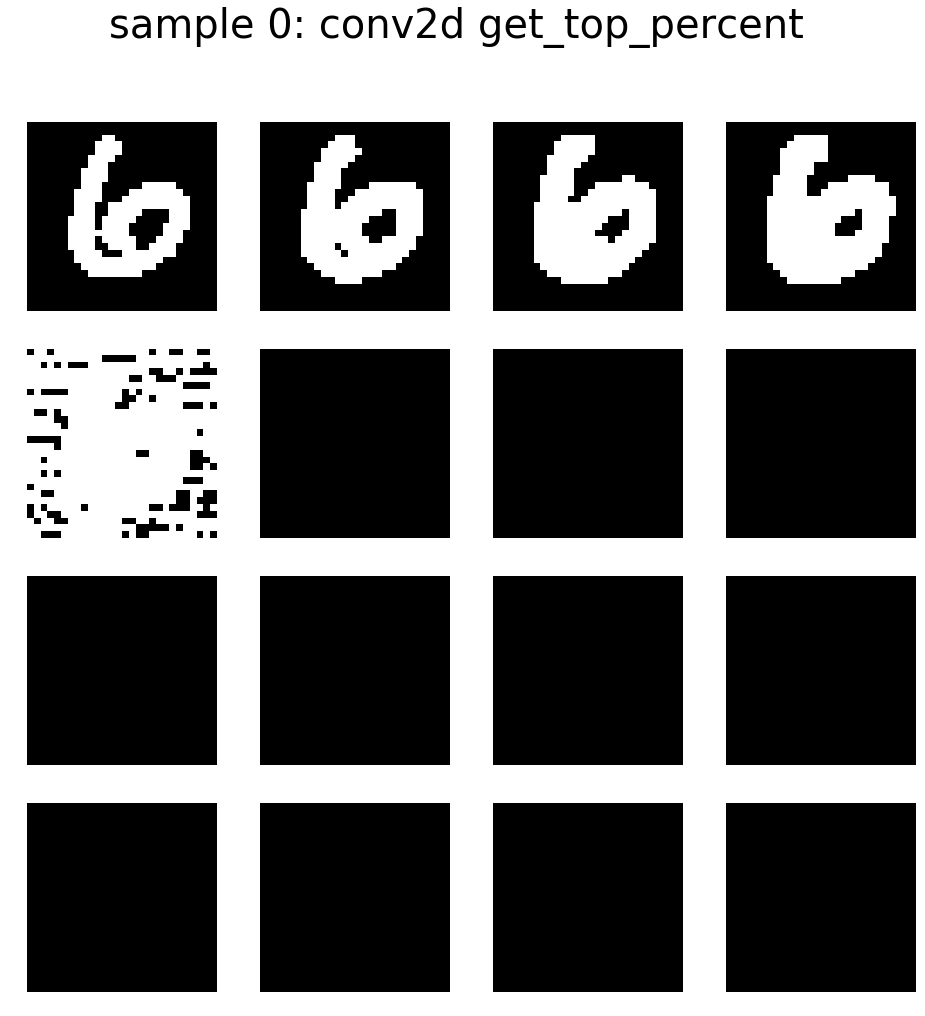

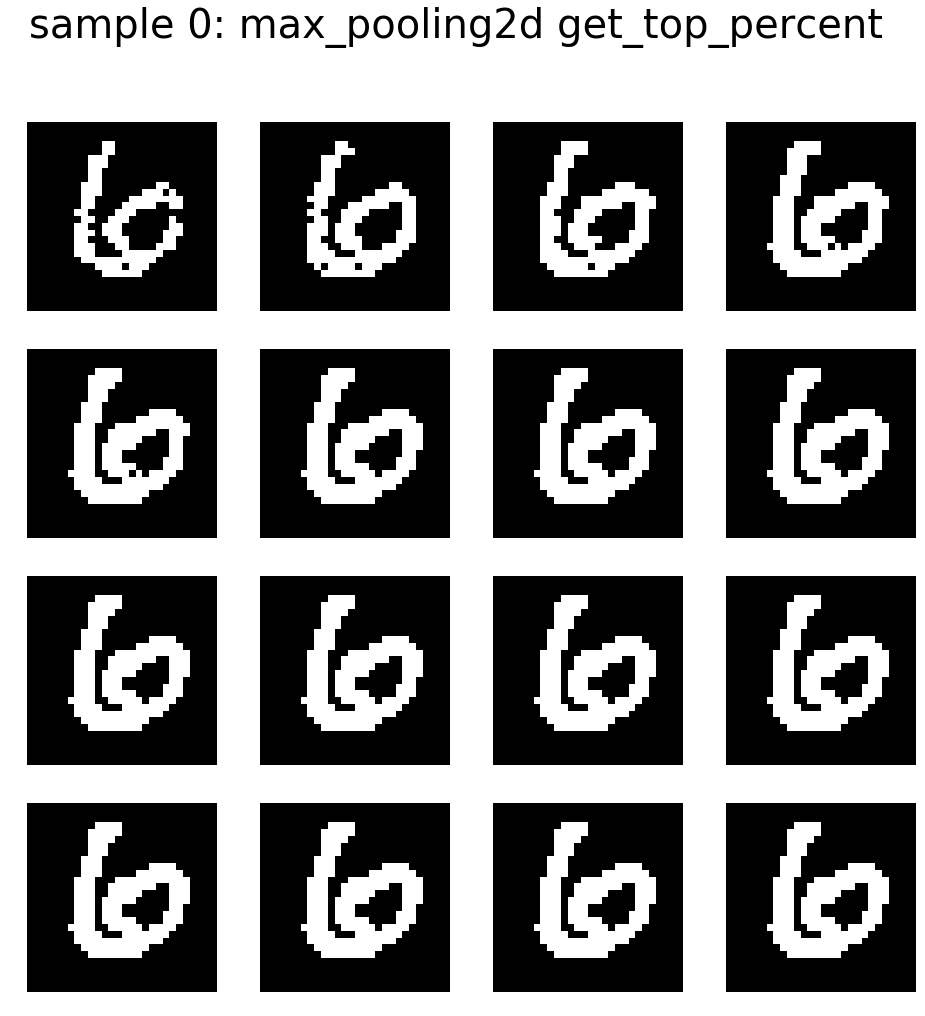

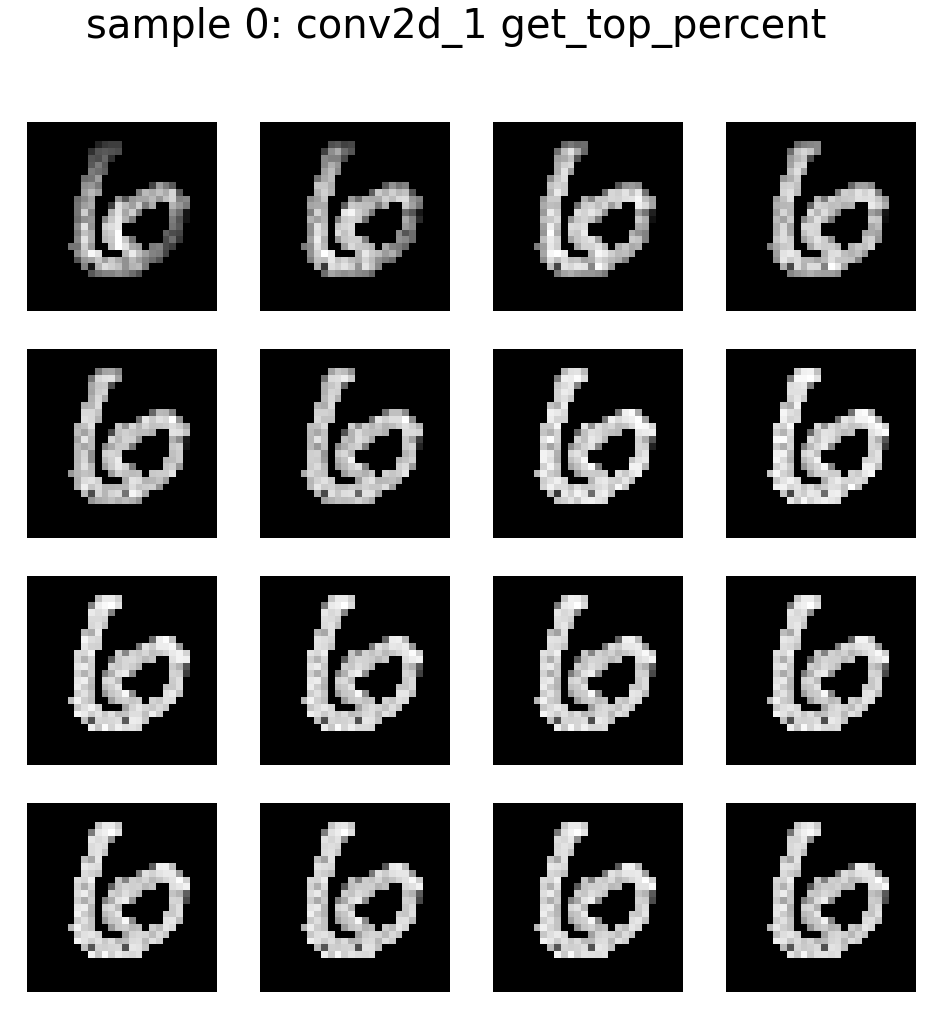

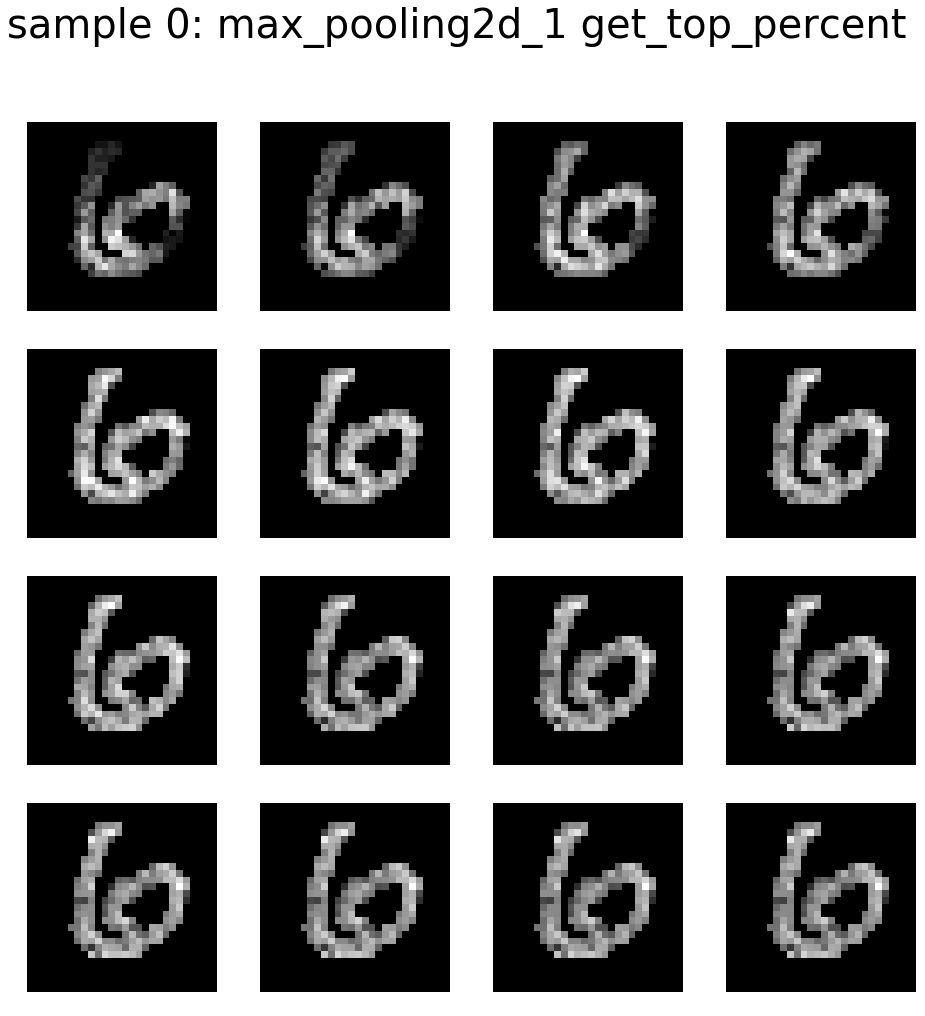

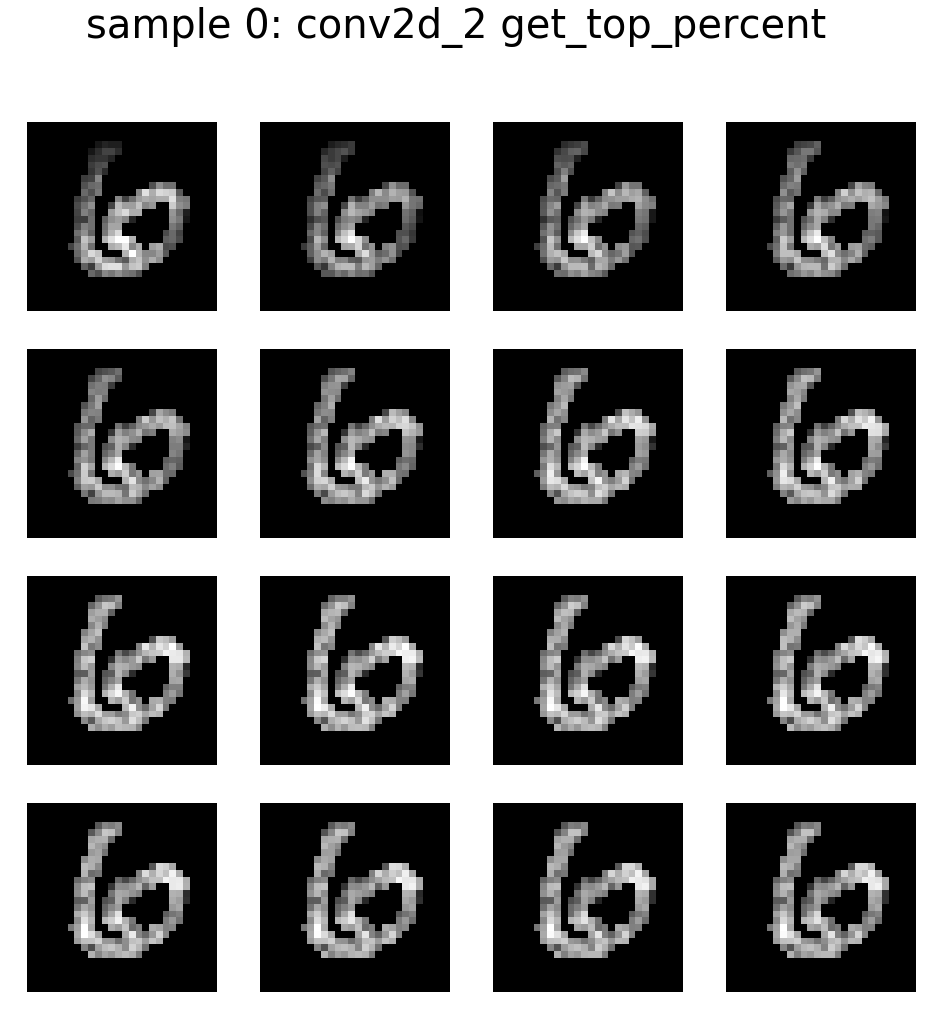

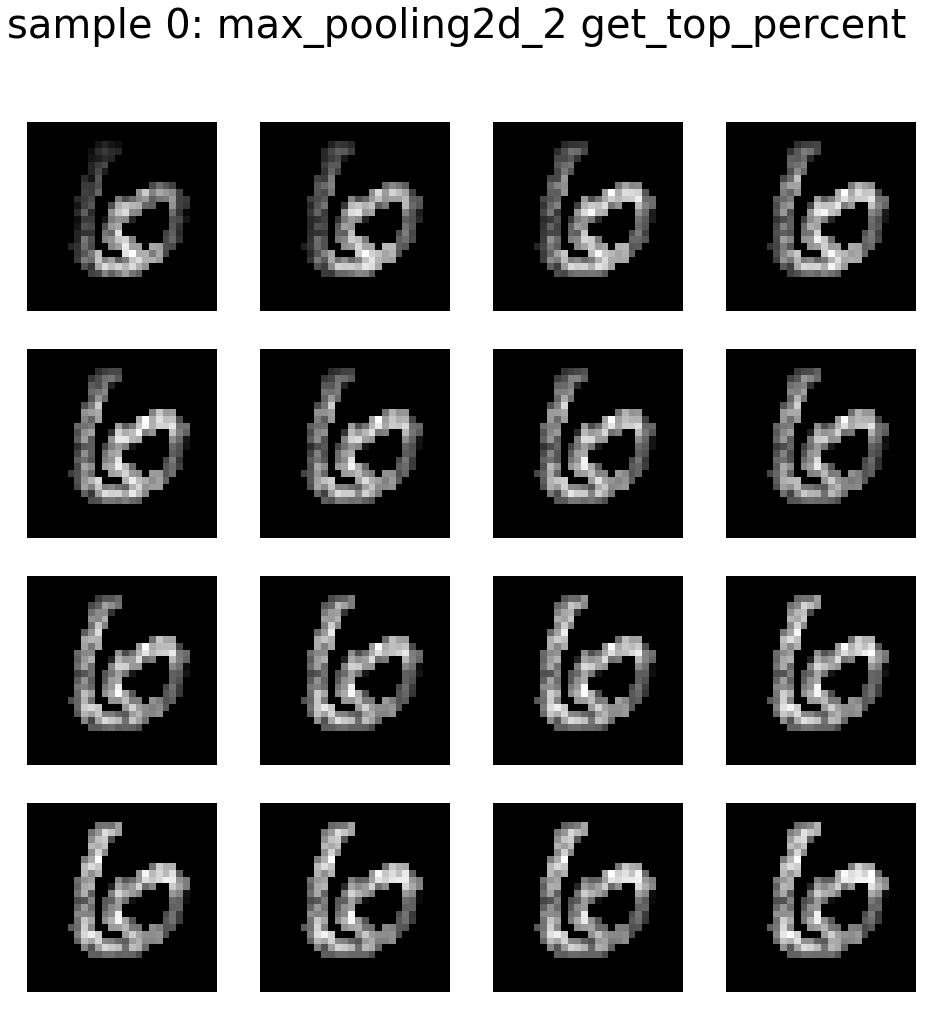

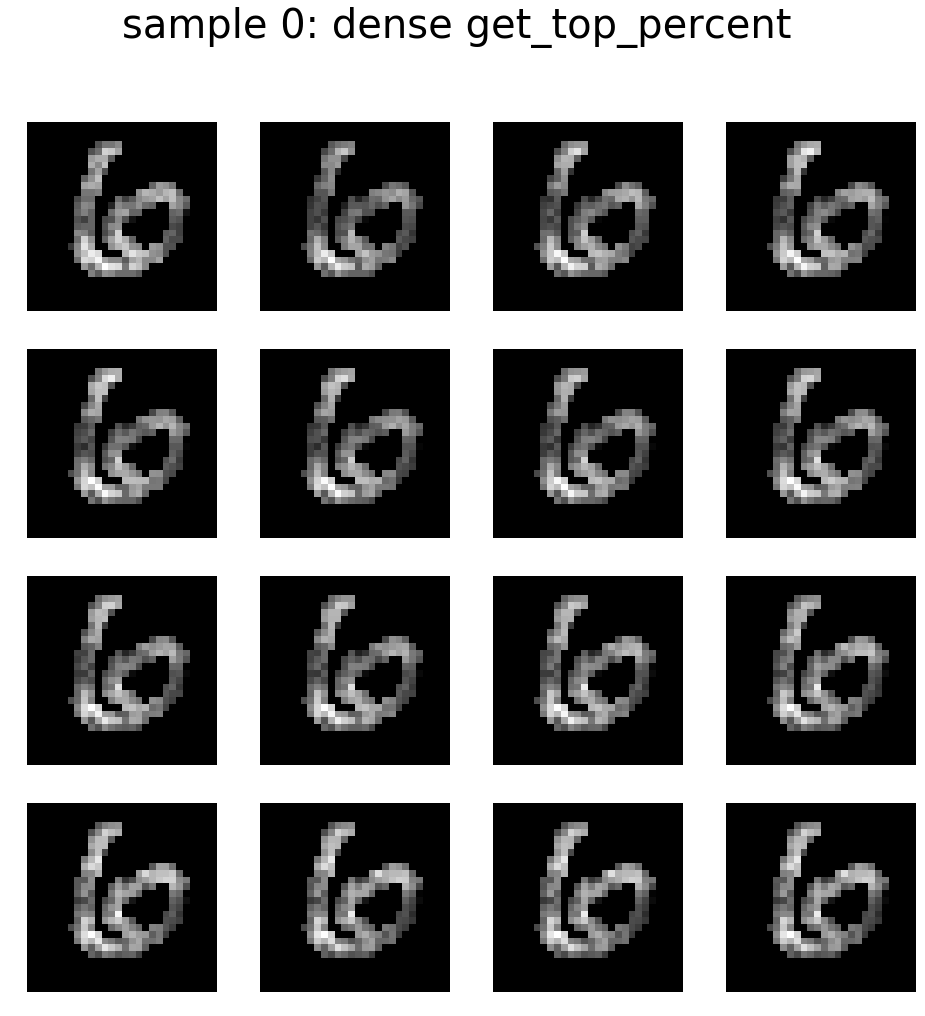

In [10]:
import matplotlib.gridspec as gridspec
def plot_guidedbackprop_percent(model, image, layer_arr, layer_name, title=''):
    
    percent_list = [i*5/100. for i in range(1, 17, 1)]
    
    manipulate_methods = ManipulativeHiddenLayer()
    hidden_extract_methods = {
        'get_top_percent': manipulate_methods.get_top_percent}
        
    n_rows = 4; n_cols = 4
    
    for method, func in hidden_extract_methods.items():
        
        gs = gridspec.GridSpec(n_rows, n_cols)
        plot_size_unit = 16
        fig = plt.figure(figsize=(plot_size_unit,
                                 plot_size_unit))
        masking_list = []
        for idx, percentage in enumerate(percent_list):
            filtered_layer = func(layer_arr, layer_arr, percentage)
            masking = (filtered_layer != 0.) * 1.
            masking_list.append(masking)

        masking_list = np.vstack(masking_list)
         
        mapping_method = ReconstructionMethod(model, layer_name, np.repeat(image, 16, axis=0), masking=masking_list) 
        gradient_input = mapping_method.guided_backpropagation()
        
        for idx in range(masking_list.shape[0]):
            guided_img = gradient_input[idx]
            row = idx // n_rows; col = idx % n_cols
            ax = fig.add_subplot(gs[row, col])
            ax.imshow(guided_img, cmap='gray')
            ax.axis('off')

        fig.suptitle(title + ' ' + method, fontsize=40)
        plt.show()

        
sample_idx = 0    
plt.imshow(np.reshape(test_images[sample_idx], (28, 28)), cmap='gray'); plt.axis('off'); plt.show()
layer_names = ['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2',
                  'max_pooling2d_2', 'dense']
test_pool_data = extract_all_feature(extractors, test_images[sample_idx:sample_idx+1])

for layer_idx, layer_name in enumerate(layer_names):
    title = 'sample ' + str(sample_idx) + ': ' + layer_name
    plot_guidedbackprop_percent(convnet, test_images[sample_idx:sample_idx+1], test_pool_data[layer_idx], layer_name, title)

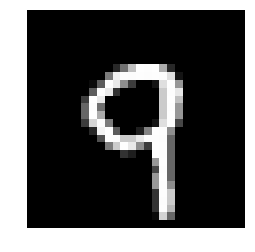

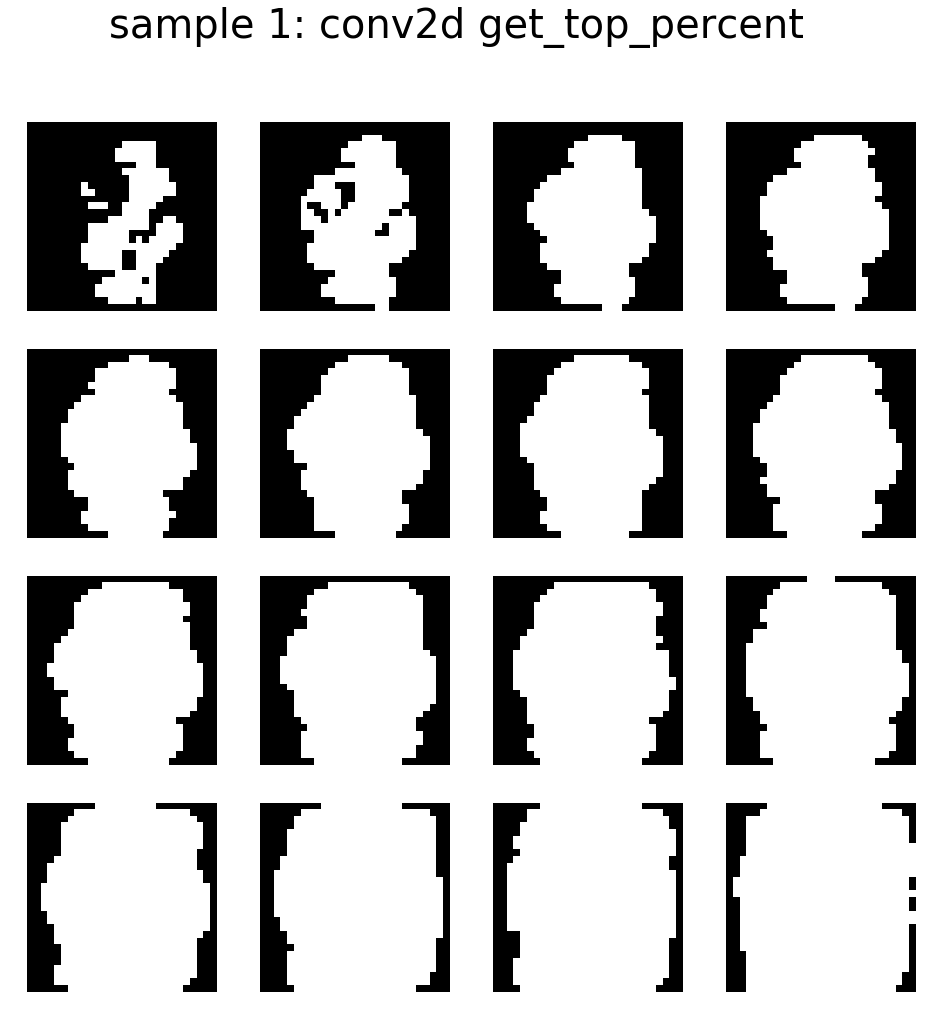

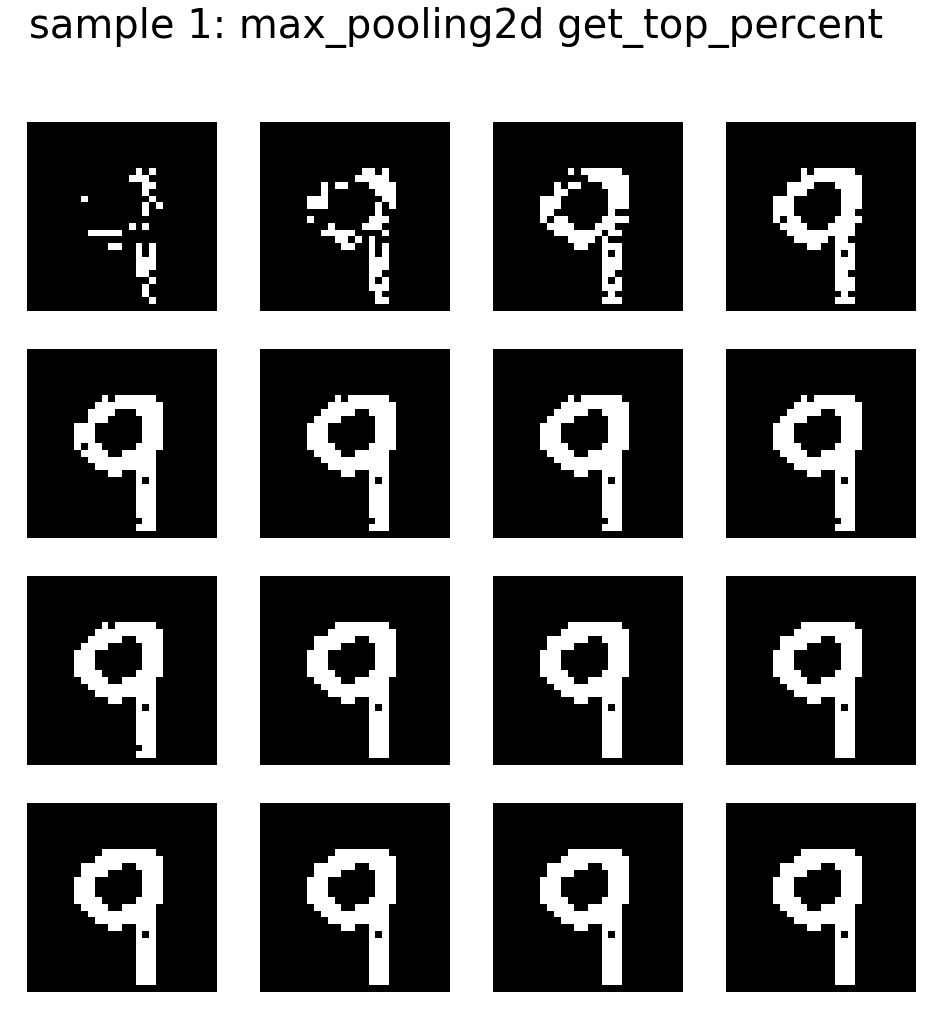

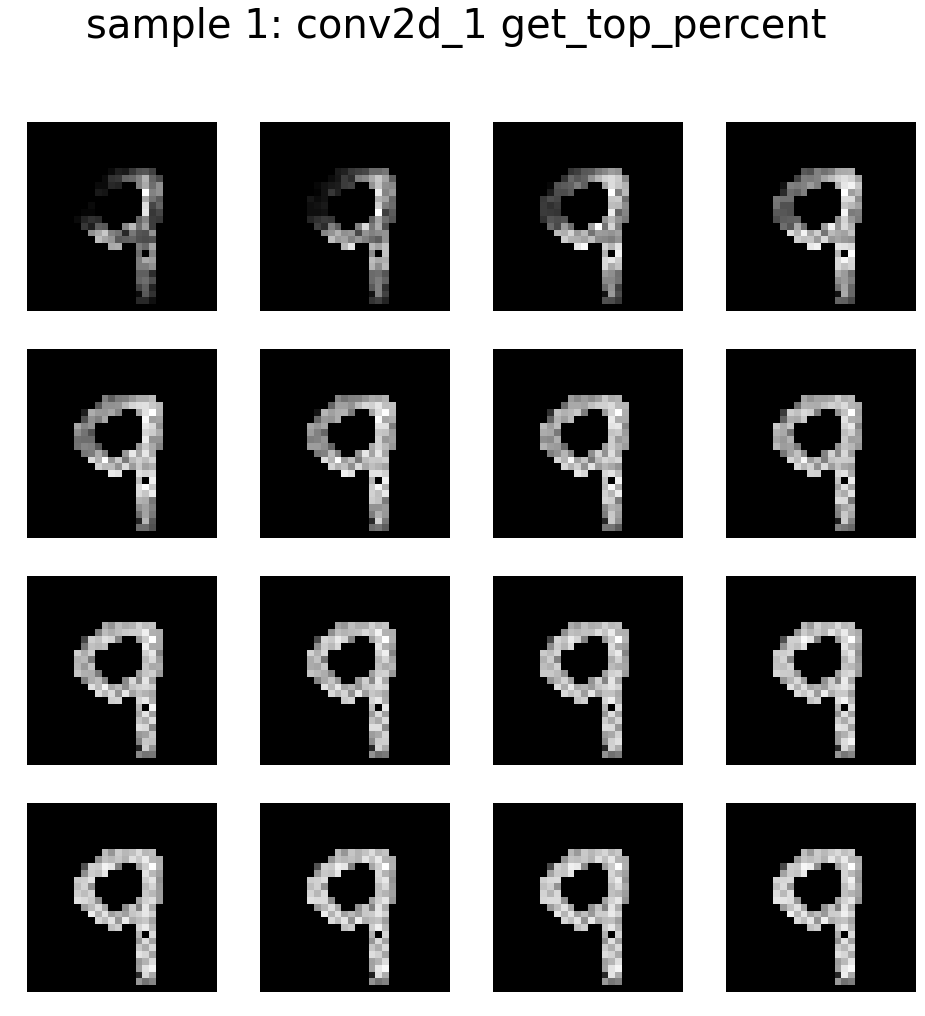

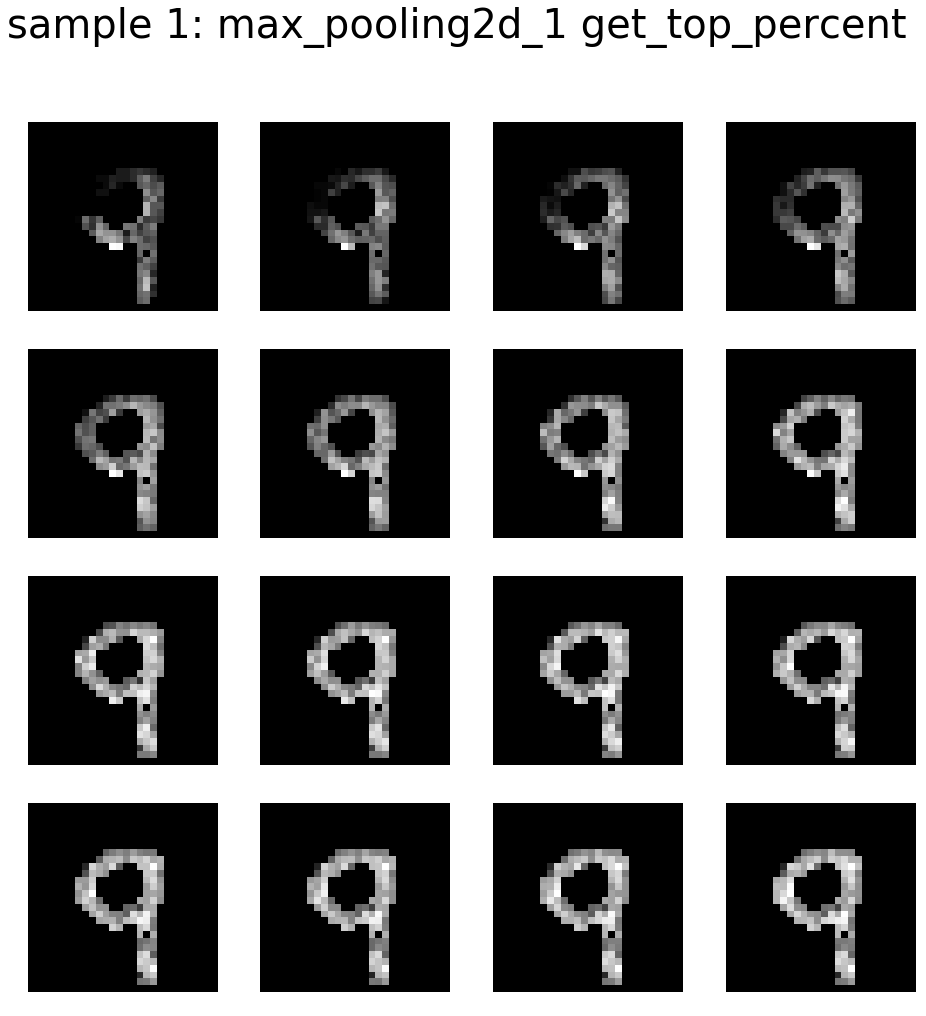

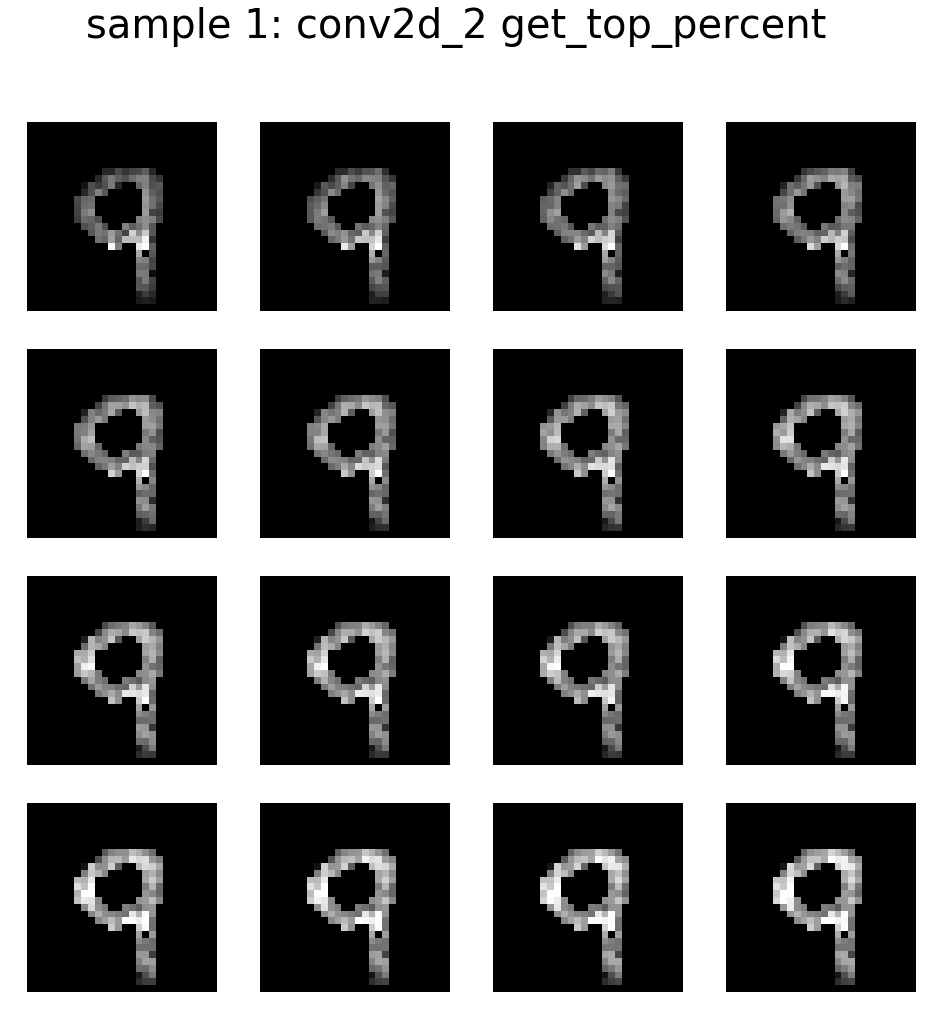

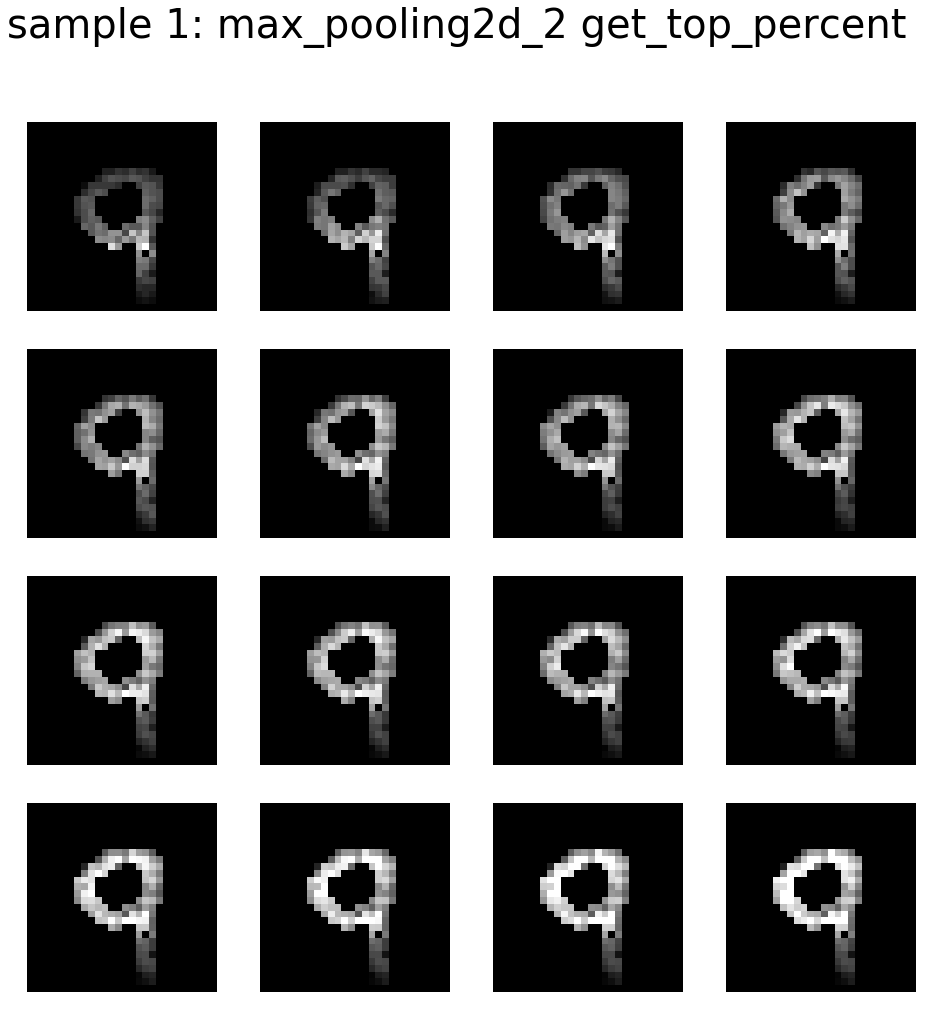

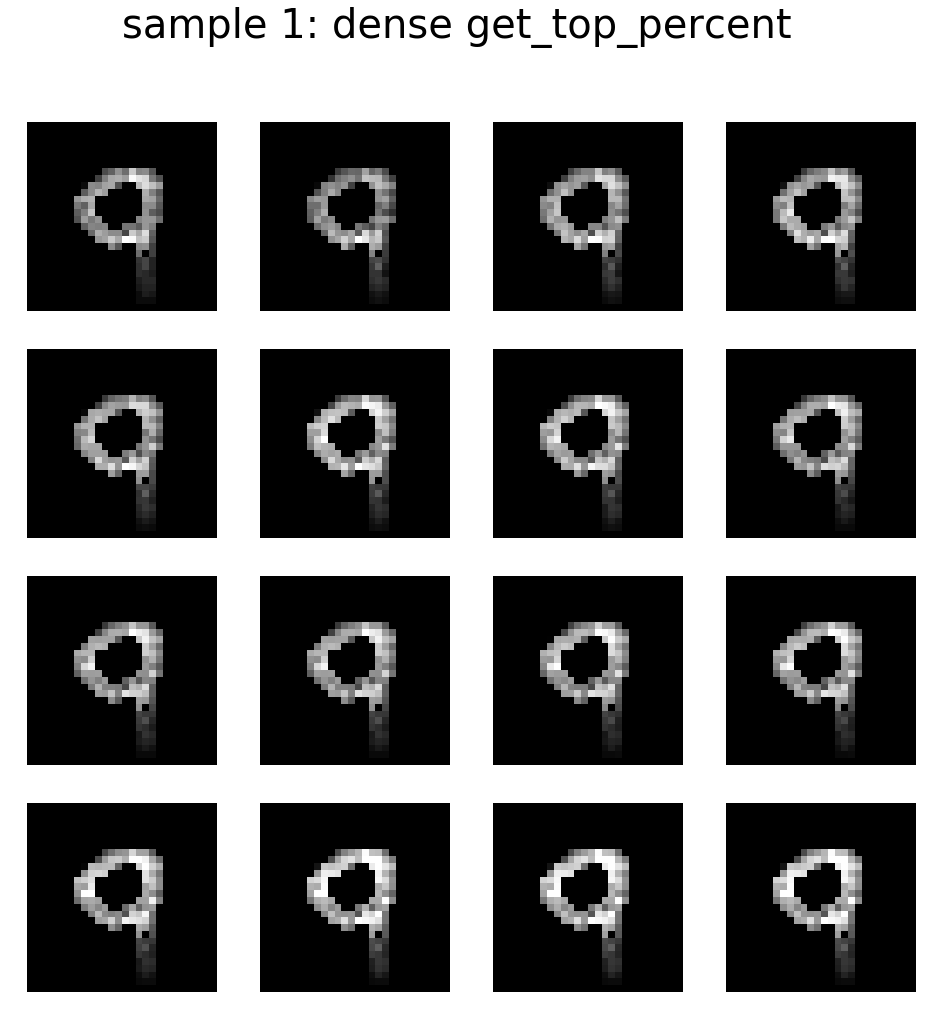

In [11]:
def plot_mim_guidedbackprop_percent(model, image, layer_arr, inf_mask, layer_name, title=''):
    
    percent_list = [i*5/100. for i in range(1, 17, 1)]
    
    manipulate_methods = ManipulativeHiddenLayer()
    hidden_extract_methods = {
        'get_top_percent': manipulate_methods.get_top_percent}
        
    n_rows = 4; n_cols = 4
    
    for method, func in hidden_extract_methods.items():
        
        gs = gridspec.GridSpec(n_rows, n_cols)
        plot_size_unit = 16
        fig = plt.figure(figsize=(plot_size_unit,
                                 plot_size_unit))
        masking_list = []
        for idx, percentage in enumerate(percent_list):
            filtered_layer = func(layer_arr, inf_mask, percentage)
            masking = (filtered_layer != 0.) * 1.
            masking_list.append(masking)

        masking_list = np.vstack(masking_list)
         
        mapping_method = ReconstructionMethod(model, layer_name, np.repeat(image, 16, axis=0), masking=masking_list) 
        gradient_input = mapping_method.guided_backpropagation()
        for idx in range(masking_list.shape[0]):
            guided_img = gradient_input[idx]
            row = idx // n_rows; col = idx % n_cols
            ax = fig.add_subplot(gs[row, col])
            ax.imshow(guided_img, cmap='gray')
            ax.axis('off')

        fig.suptitle(title + ' ' + method, fontsize=40)
        plt.show()

        
sample_idx = 1
labels = np.concatenate((train_labels, test_labels[sample_idx:sample_idx+1]), axis=0)
data = np.concatenate((train_images, test_images[sample_idx:sample_idx+1]), axis=0)
pool_data = extract_all_feature(extractors, data)
plt.imshow(np.reshape(test_images[sample_idx], (28, 28)), cmap='gray'); plt.axis('off'); plt.show()
layer_names = ['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2',
                  'max_pooling2d_2', 'dense']

for layer_idx, layer_name in enumerate(layer_names):

    data_hidden = pool_data[layer_idx]
    data_flatten = data_hidden.reshape(data_hidden.shape[0], -1)
    mim_infl, _ = mim(data_flatten, labels, -1)
    inf_mask = mim_infl.reshape(pool_data[layer_idx].shape[1:])    
    title = 'sample ' + str(sample_idx) + ': ' + layer_name
    plot_mim_guidedbackprop_percent(convnet, test_images[sample_idx:sample_idx+1], pool_data[layer_idx][-1:], inf_mask, layer_name, title)

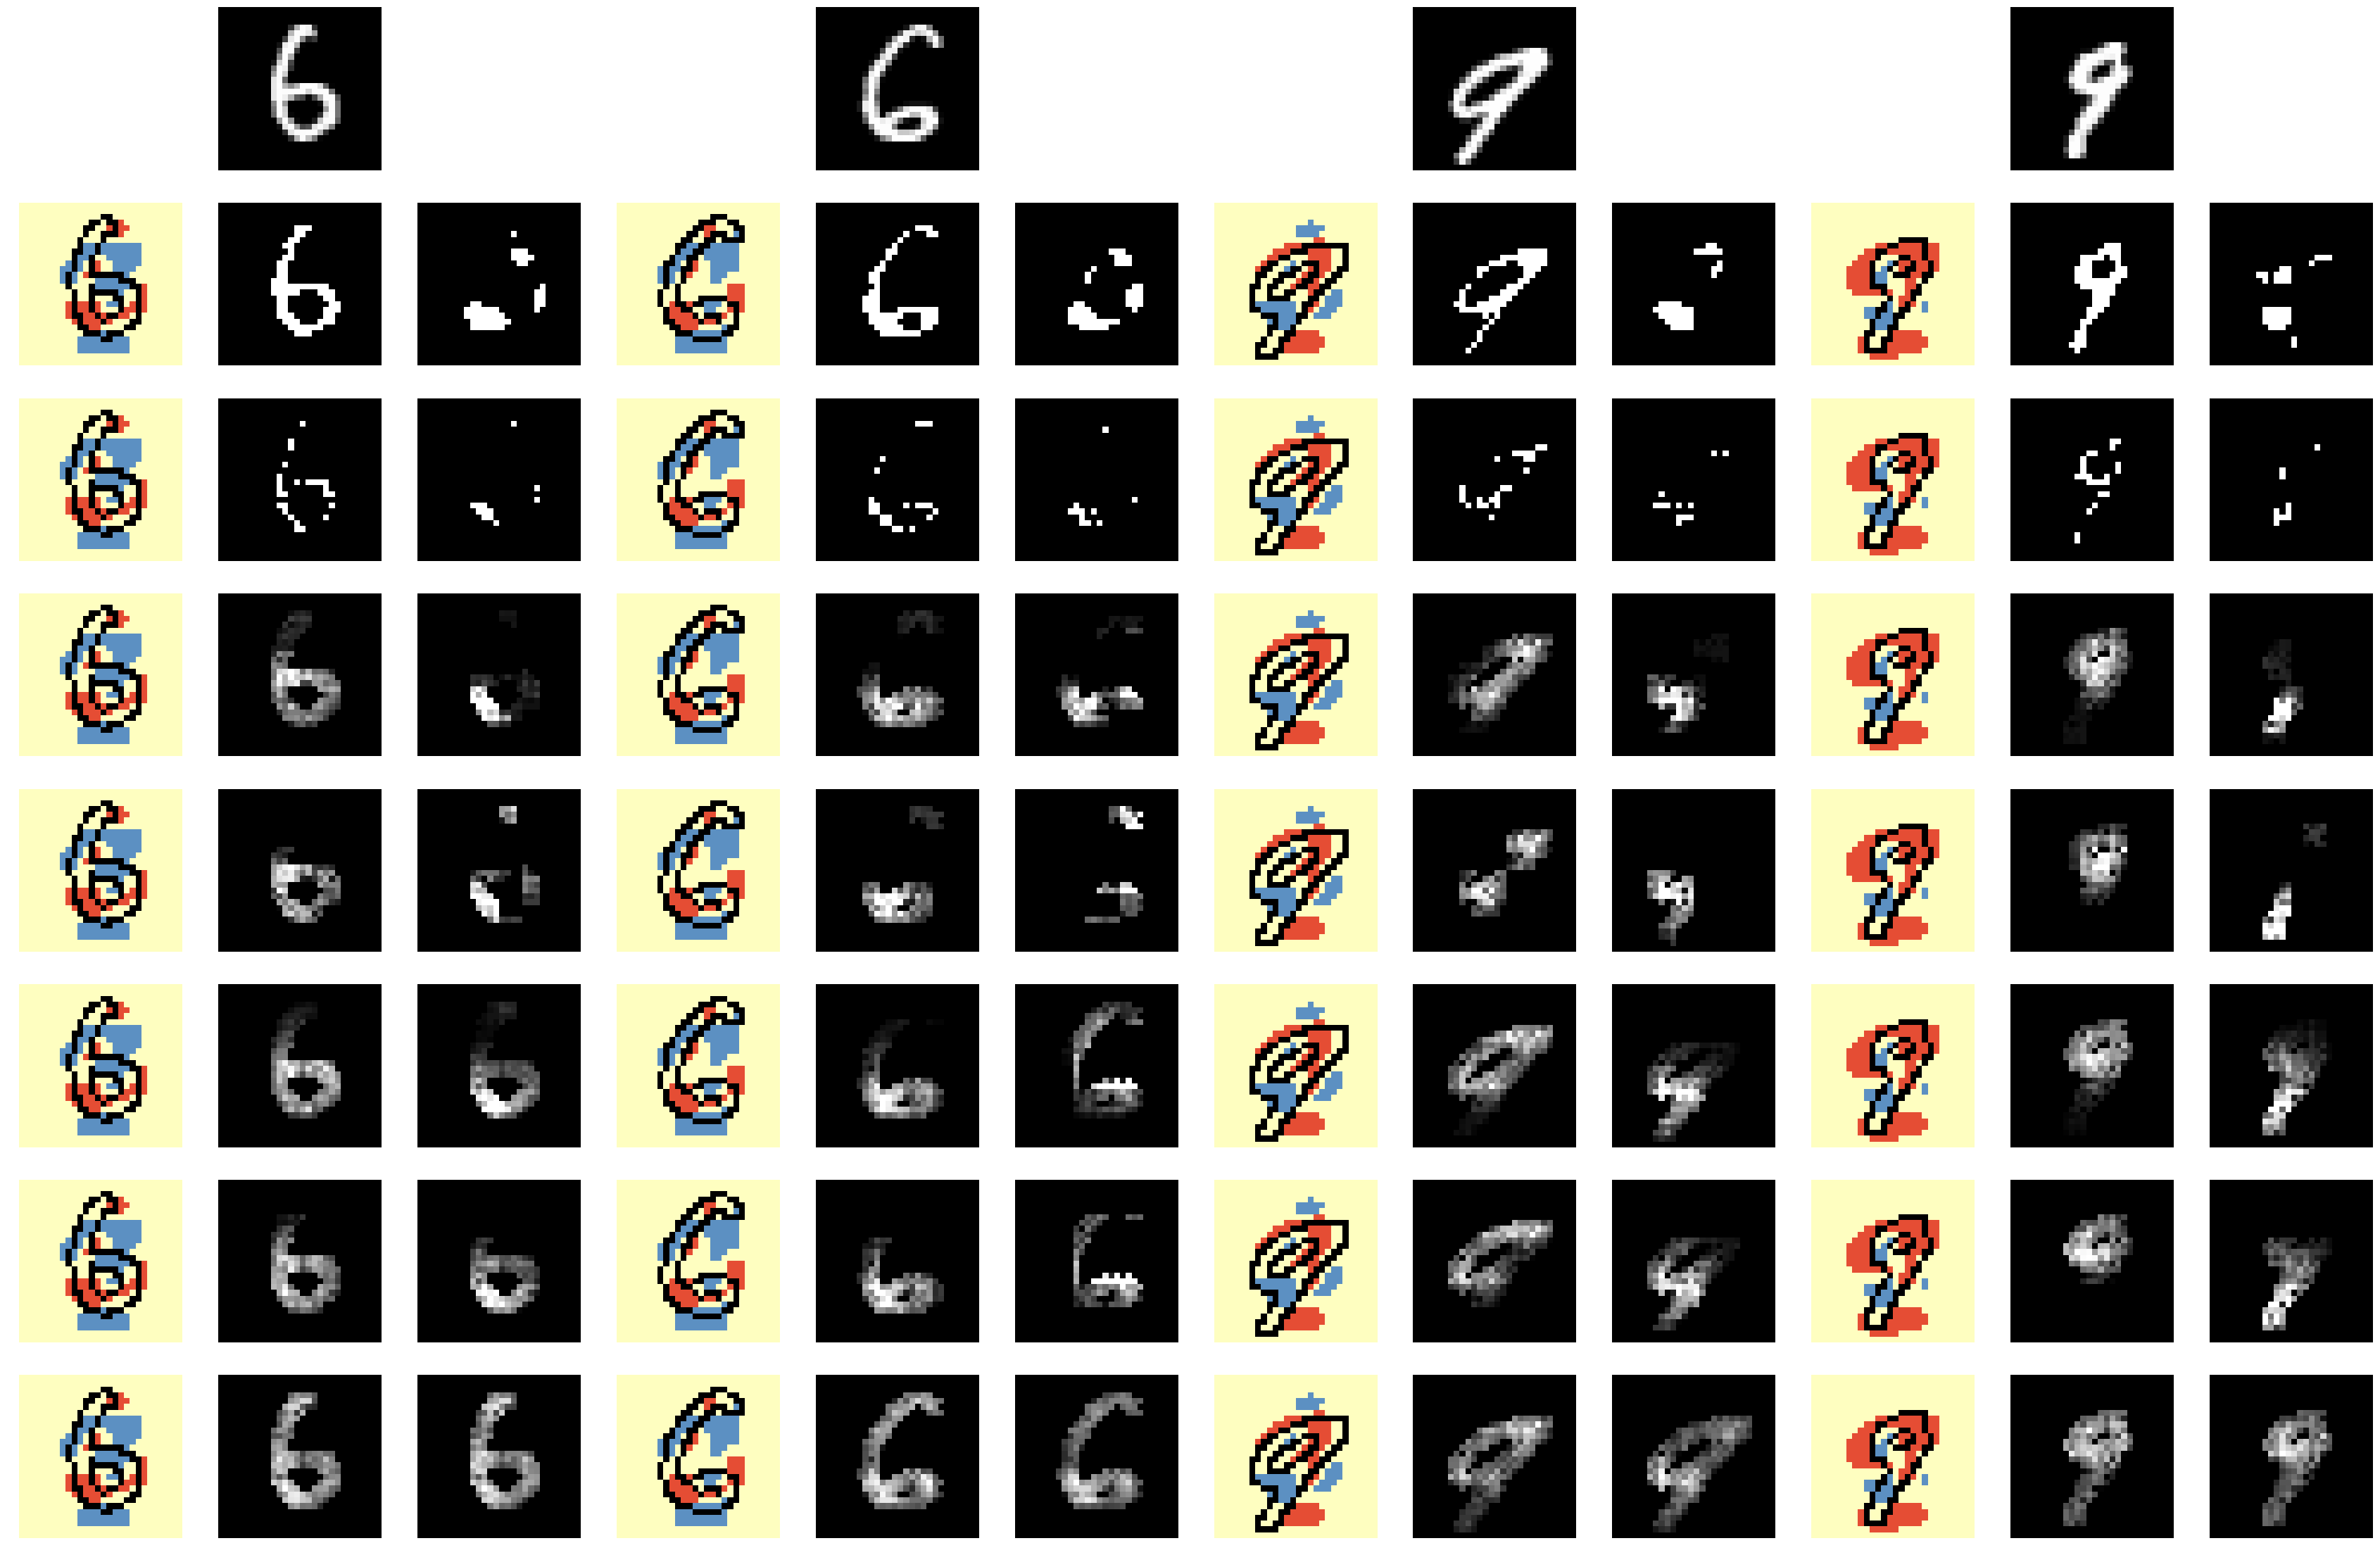

In [25]:
from skimage import feature

def create_heatmap_MIM(influence_mask, input_image):
    
    def normalize_pic(img):
        min_img = img.min()
        max_img = img.max()
        normalized = (img - min_img) / (max_img - min_img) 
        return normalized

    def edge_detect(img):
        edges = feature.canny(img) # detect edge
        edges = 1 - edges # flip color
        return edges

    normalized_influence = normalize_pic(influence_mask)
    edged_image = edge_detect(input_image)
    edged_x, edged_y = np.nonzero(1 - edged_image)
    
    count, bins = np.histogram(normalized_influence, 3)
    negative = normalized_influence < bins[1]
    zero = np.logical_and(normalized_influence >= bins[1], normalized_influence < bins[2])
    positive = normalized_influence >= bins[2]

    normalized_influence[negative] = 0.15
    normalized_influence[zero] = 0.5
    normalized_influence[positive] = 0.85
    heatmap_image = Image.fromarray(np.uint8(plt.cm.RdYlBu(normalized_influence)*255))

    pixels = heatmap_image.load()
    for x, y in zip(edged_x, edged_y):
        heatmap_image.putpixel((y, x), (0, 0, 0))
    return heatmap_image

def plot_mim_guidedmim_guidedbackprop_layerwise(model, input_data, layer_names, sample_idx_list, percent_list):
    n_rows = 8
    n_cols = 12
    
    gs = gridspec.GridSpec(n_rows, n_cols)
    fig = plt.figure(figsize=(60, 40))
    
    (train_images, test_images, train_prediction, test_prediction) = input_data
    for col in range(4):

        sample_idx = sample_idx_list[col]
        labels = np.concatenate((train_prediction, test_prediction[sample_idx:sample_idx+1]), axis=0)
        data = np.concatenate((train_images, test_images[sample_idx:sample_idx+1]), axis=0)
        pool_data = extract_all_feature(extractors, data)
        
        # calculate mim here
        data_hidden = np.copy(data)
        data_flatten = data_hidden.reshape(data_hidden.shape[0], -1)
        mim_infl, _ = mim(data_flatten, labels, -1)
        inf_mask = mim_infl.reshape(data_hidden.shape[1:3]) 
        input_image = data[-1, :, :, 0]
        heatmap_image = create_heatmap_MIM(inf_mask*-1., input_image)
        
        ax = fig.add_subplot(gs[0, col*3 + 1])
        ax.imshow(input_image, cmap='gray'); ax.axis('off')
        
        for row in range(1, n_rows):
            ax = fig.add_subplot(gs[row, col*3])
            ax.imshow(heatmap_image); ax.axis('off')
            
        for row in range(n_rows-1):
            layer_name = layer_names[row]
            data_hidden = pool_data[row]
            data_flatten = data_hidden.reshape(data_hidden.shape[0], -1)
            mim_infl, _ = mim(data_flatten, labels, -1)
            inf_mask = mim_infl.reshape(data_hidden.shape[1:])    

            percentage = percent_list[col][row]   
            manipulate_methods = ManipulativeHiddenLayer()
            
            # plot guided-backprop
            filtered_layer = manipulate_methods.get_top_percent(pool_data[row][-1:], 
                                                                pool_data[row][-1:], percentage)
            masking = (filtered_layer != 0.) * 1.
            mapping_method = ReconstructionMethod(model, layer_name, test_images[sample_idx:sample_idx+1], masking=masking) 
            gradient_input = mapping_method.guided_backpropagation()[0]
 
            ax = fig.add_subplot(gs[row+1, col*3+1])
            ax.imshow(gradient_input, cmap='gray'); ax.axis('off')

            # plot guided-mim
            filtered_layer = manipulate_methods.get_top_percent(pool_data[row][-1:], 
                                                                inf_mask, percentage)
            masking = (filtered_layer != 0.) * 1.
            mapping_method = ReconstructionMethod(model, layer_name, test_images[sample_idx:sample_idx+1], masking=masking) 
            gradient_input = mapping_method.guided_backpropagation()[0]
            
            ax = fig.add_subplot(gs[row+1, col*3+2])
            ax.imshow(gradient_input, cmap='gray'); ax.axis('off')
                        
    plt.show()
        
sample_idx_list = [1, 9, -19, -36]
train_prediction = convnet.predict_classes(train_images).flatten()
test_prediction = convnet.predict_classes(test_images).flatten()
layer_names = ['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2',
                  'max_pooling2d_2', 'dense']
percentage = 0.005
'''
percent_list = [[percentage, percentage/(1./4), percentage/(1./2), percentage/(1./8), 
                 percentage/(1./8), percentage/(1./32)] for i in range(4)]
'''
percent_list = [[percentage]*7 for i in range(4)]
plot_mim_guidedmim_guidedbackprop_layerwise(convnet, 
                                            (train_images, test_images, train_prediction, test_prediction), 
                                            layer_names,
                                            sample_idx_list,
                                           percent_list)

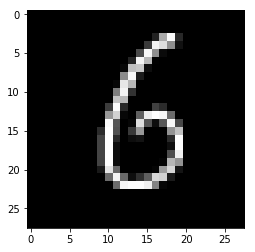

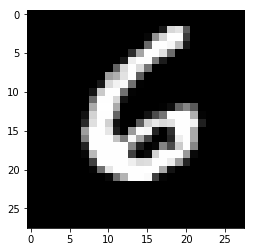

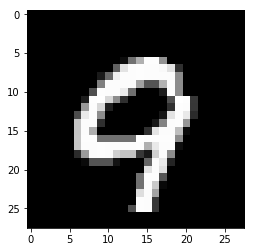

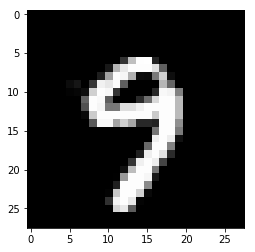

In [19]:
for i in [1, 9, -19, -36]:
    plt.imshow(train_images[i, ..., 0], cmap='gray'); plt.show()

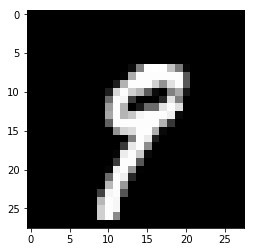

-20


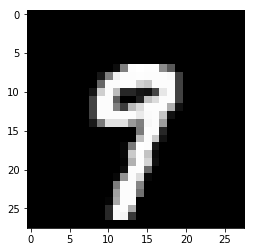

-21


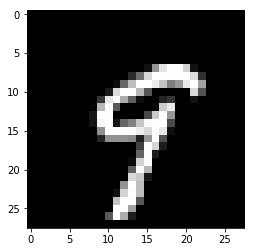

-22


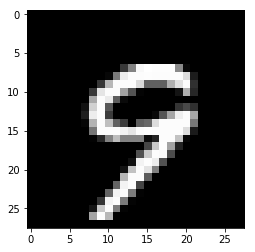

-23


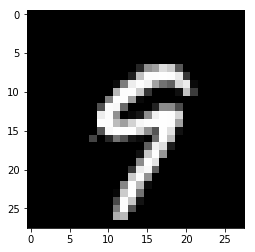

-24


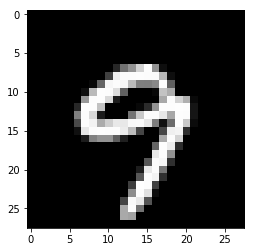

-25


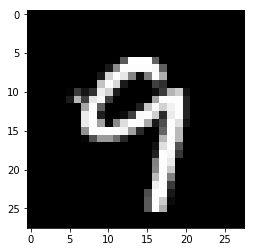

-26


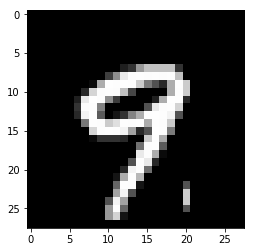

-27


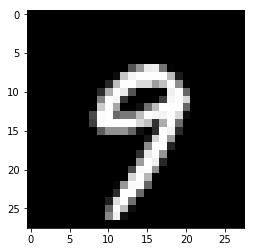

-28


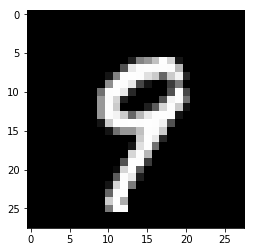

-29


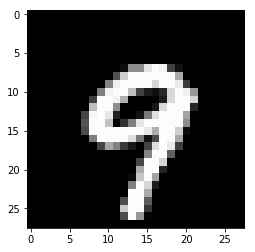

-30


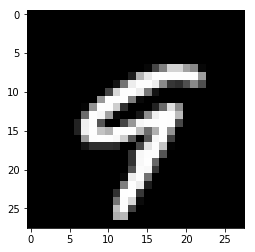

-31


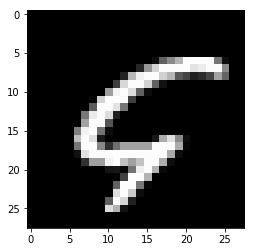

-32


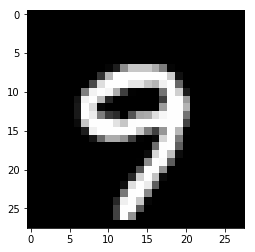

-33


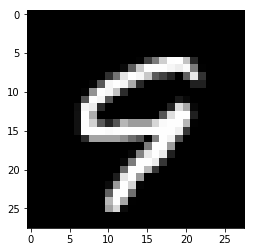

-34


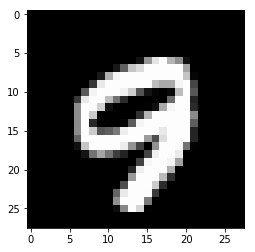

-35


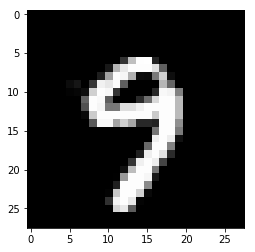

-36


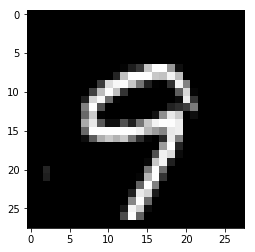

-37


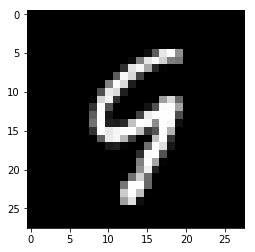

-38


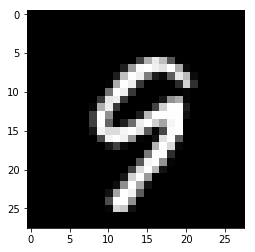

-39


In [18]:
for i in range(20, 40):
    plt.imshow(train_images[-i, ..., 0], cmap='gray'); plt.show(); print (-i)

In [32]:
_ = extract_all_feature(extractors, train_images[:1])
for i in _:
    s = i.shape[1:]
    print (s)

(28, 28, 32)
(14, 14, 32)
(14, 14, 64)
(7, 7, 64)
(7, 7, 64)
(3, 3, 64)
(64,)


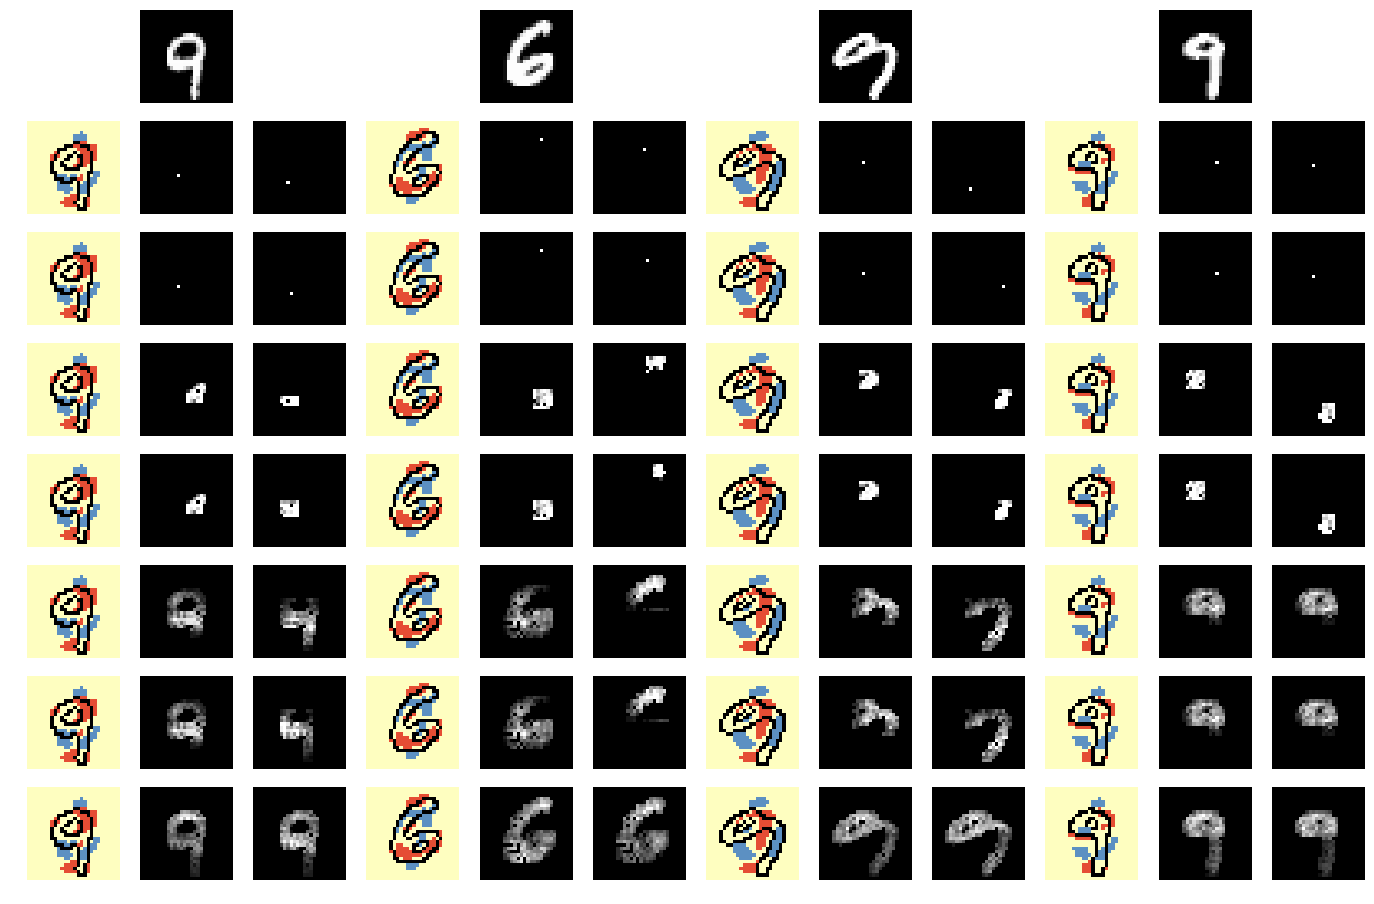

In [14]:
from skimage import feature
import matplotlib.gridspec as gridspec

def create_heatmap_MIM(influence_mask, input_image):
    
    def normalize_pic(img):
        min_img = img.min()
        max_img = img.max()
        normalized = (img - min_img) / (max_img - min_img) 
        return normalized

    def edge_detect(img):
        edges = feature.canny(img) # detect edge
        edges = 1 - edges # flip color
        return edges

    normalized_influence = normalize_pic(influence_mask)
    edged_image = edge_detect(input_image)
    edged_x, edged_y = np.nonzero(1 - edged_image)
    
    count, bins = np.histogram(normalized_influence, 3)
    negative = normalized_influence < bins[1]
    zero = np.logical_and(normalized_influence >= bins[1], normalized_influence < bins[2])
    positive = normalized_influence >= bins[2]

    normalized_influence[negative] = 0.15
    normalized_influence[zero] = 0.5
    normalized_influence[positive] = 0.85
    heatmap_image = Image.fromarray(np.uint8(plt.cm.RdYlBu(normalized_influence)*255))

    pixels = heatmap_image.load()
    for x, y in zip(edged_x, edged_y):
        heatmap_image.putpixel((y, x), (0, 0, 0))
    return heatmap_image

def plot_mim_guidedmim_guidedbackprop_1unit_all(model, input_data, layer_names, sample_idx_list):
    n_rows = 8
    n_cols = 12
    
    gs = gridspec.GridSpec(n_rows, n_cols)
    fig = plt.figure(figsize=(24, 16))
    
    (train_images, test_images, train_prediction, test_prediction) = input_data
    for col in range(4):

        sample_idx = sample_idx_list[col]
        labels = np.concatenate((train_prediction, test_prediction[sample_idx:sample_idx+1]), axis=0)
        data = np.concatenate((train_images, test_images[sample_idx:sample_idx+1]), axis=0)
        pool_data = extract_all_feature(extractors, data)
        
        # calculate mim here
        data_hidden = np.copy(data)
        data_flatten = data_hidden.reshape(data_hidden.shape[0], -1)
        mim_infl, _ = mim(data_flatten, labels, -1)
        inf_mask = mim_infl.reshape(data_hidden.shape[1:3]) 
        input_image = data[-1, :, :, 0]
        heatmap_image = create_heatmap_MIM(inf_mask*-1., input_image)
        
        ax = fig.add_subplot(gs[0, col*3 + 1])
        ax.imshow(input_image, cmap='gray'); ax.axis('off')
        
        for row in range(1, n_rows):
            ax = fig.add_subplot(gs[row, col*3])
            ax.imshow(heatmap_image); ax.axis('off')
            
        for row in range(n_rows-1):
            layer_name = layer_names[row]
            data_hidden = pool_data[row]
            data_flatten = data_hidden.reshape(data_hidden.shape[0], -1)
            mim_infl, _ = mim(data_flatten, labels, -1)
            inf_mask = mim_infl.reshape(data_hidden.shape[1:])    

            manipulate_methods = ManipulativeHiddenLayer()
            
            # plot guided-backprop
            masking = manipulate_methods.get_top_1unit(pool_data[row][-1:],pool_data[row][-1:])
            mapping_method = ReconstructionMethod(model, layer_name, test_images[sample_idx:sample_idx+1], masking=masking) 
            gradient_input = mapping_method.guided_backpropagation()[0]
 
            ax = fig.add_subplot(gs[row+1, col*3+1])
            ax.imshow(gradient_input, cmap='gray'); ax.axis('off')

            # plot guided-mim
            masking = manipulate_methods.get_top_1unit(pool_data[row][-1:], inf_mask)
            mapping_method = ReconstructionMethod(model, layer_name, test_images[sample_idx:sample_idx+1], masking=masking) 
            gradient_input = mapping_method.guided_backpropagation()[0]
            
            ax = fig.add_subplot(gs[row+1, col*3+2])
            ax.imshow(gradient_input, cmap='gray'); ax.axis('off')
                        
    plt.show()
        
sample_idx_list = [0, 1, 3 , 4]
train_prediction = convnet.predict_classes(train_images).flatten()
test_prediction = convnet.predict_classes(test_images).flatten()
layer_names = ['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2',
                  'max_pooling2d_2', 'dense']
plot_mim_guidedmim_guidedbackprop_1unit_all(convnet, 
                                            (train_images, test_images, train_prediction, test_prediction), 
                                            layer_names,
                                            sample_idx_list)

In [121]:
percentage = 0.01
nmb_units = int(percentage * 784) 
percent_list = [[nmb_units, nmb_units/4, nmb_units/2, nmb_units/8, nmb_units/8, nmb_units/32] for i in range(4)]
print (percent_list)

[[0.01, 0.0025, 0.005, 0.00125, 0.00125, 0.0003125], [0.01, 0.0025, 0.005, 0.00125, 0.00125, 0.0003125], [0.01, 0.0025, 0.005, 0.00125, 0.00125, 0.0003125], [0.01, 0.0025, 0.005, 0.00125, 0.00125, 0.0003125]]


In [34]:
from numpy import linalg as LA
from matplotlib.patches import Rectangle, Patch
from matplotlib.lines import Line2D

# Calculate the normalized MIM score for each layer to identify the most influential layer of CNN.

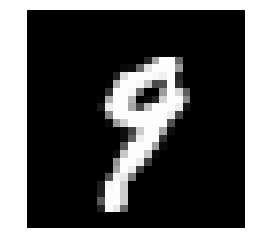

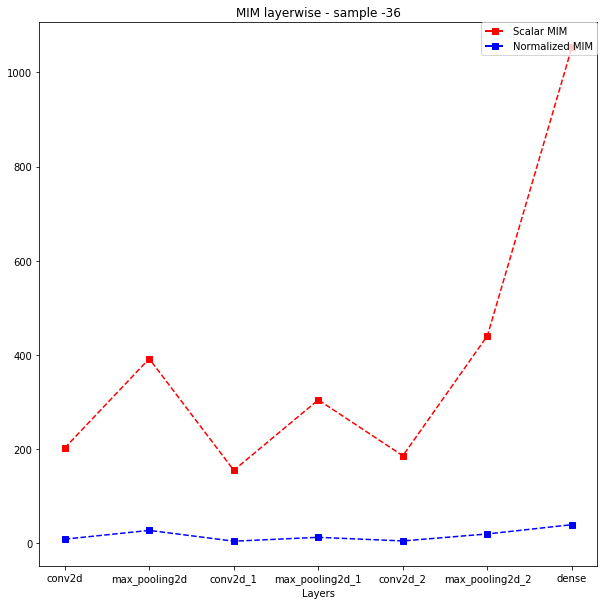

[7.634400161305546, 26.320781304035826, 3.3709233568771966, 11.603389954766993, 3.8852095284761092, 18.76643859775641, 38.47955034615365]


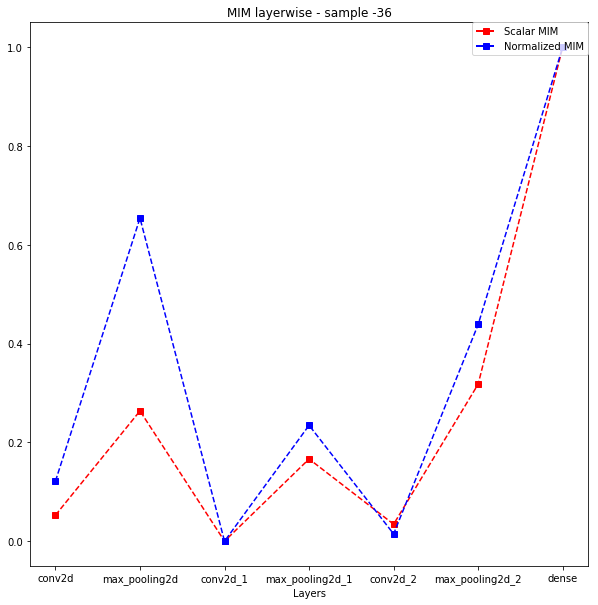

In [39]:
def plot_mim_layerwise(pool_data, labels, layer_idx_list, layer_names, is_normed=False):
    mim_infl_layers = []
    normed_mim_infl_layers = []
    
    for i in layer_idx_list:
        data_flatten = pool_data[i].reshape(pool_data[i].shape[0],-1)
        mim_infl, distance = mim(data_flatten, labels, -1)
        mim_infl_layers.append(LA.norm(mim_infl))
        normed_mim_infl_layers.append(LA.norm(mim_infl) / distance.max())
    
    def normalize_arr(arr):
        min_arr = min(arr); max_arr = max(arr)
        return (arr - min_arr)/(max_arr - min_arr)
    
    if (is_normed is True):
        mim_infl_layers = normalize_arr(np.array(mim_infl_layers))
        print (normed_mim_infl_layers)
        normed_mim_infl_layers = normalize_arr(np.array(normed_mim_infl_layers))
        
    plot_size_unit = 10
    fig = plt.figure(figsize=(plot_size_unit,
                            plot_size_unit))
    plt.plot(layer_idx_list, mim_infl_layers, 'rs--', label='Scalar MIM')
    plt.plot(layer_idx_list, normed_mim_infl_layers, 'bs--', label='Normalized MIM')
    plt.xticks(layer_idx_list)
    plt.xlabel('Layers')
    legend_elements = [Line2D([0], [0], color='r', linestyle='--', marker='s', lw=2, label='Scalar MIM'),
                      Line2D([0], [0], color='b', linestyle='--', marker='s', lw=2, label='Normalized MIM')]
    plt.legend(handles=legend_elements, loc=1, borderaxespad=0.)
    plt.xticks([i for i in range(len(layer_names))], layer_names)
    plt.title('MIM layerwise - sample '+str(sample_idx))
    plt.show()  
    
    
    
sample_idx = -36 
# 0.0001: [1, 9, -19, -36]
# all 12 samples: 
labels = np.concatenate((train_labels, test_labels[sample_idx:sample_idx+1]), axis=0)
data = np.concatenate((train_images, test_images[sample_idx:sample_idx+1]), axis=0)
pool_data = extract_all_feature(extractors, data)
plt.imshow(np.reshape(test_images[sample_idx], (28, 28)), cmap='gray'); plt.axis('off'); plt.show()
layer_names = ['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2',
                  'max_pooling2d_2', 'dense']
numb_layers = len(layer_names)

plot_mim_layerwise(pool_data, labels, [i for i in range(numb_layers)], layer_names)
plot_mim_layerwise(pool_data, labels, [i for i in range(numb_layers)], layer_names, is_normed=True)

# Experimenting with Incremental Examples

In [43]:
def fix_in_domain(x):
    larger = x > 1.
    smaller = x < 0.
    x[larger] = 1.
    x[smaller] = 0.
    return x

In [44]:
prediction_train = convnet.predict_classes(train_images)
prediction_test = convnet.predict_classes(test_images)
modified_test_images = np.copy(test_images)
for i in range(test_images.shape[0]):
    if (i%100 == 0):
        print (i)
        
    labels = np.concatenate((prediction_train, prediction_test[i:i+1]), axis=0)
    data = np.concatenate((train_images, test_images[i:i+1]), axis=0)
    data_flatten = data.reshape(data.shape[0], -1)
    mim_infl, _ = mim(data_flatten, labels, -1)
    inf_mask = mim_infl.reshape(data[-1].shape)
    modified_test_images[i] = fix_in_domain(modified_test_images[i] + inf_mask)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [45]:
print ('f(x) = 6', np.count_nonzero(convnet.predict_classes(test_images).flatten()))
print ('f(x) = 9', np.count_nonzero(1.-convnet.predict_classes(test_images).flatten()))
print ('f(x+MIM) = 6', np.count_nonzero(convnet.predict_classes(modified_test_images).flatten()))
print ('f(x+MIM) = 9', np.count_nonzero(1.-convnet.predict_classes(modified_test_images).flatten()))
print ('f_P(x+MIM) > f_P(x), f(x) = 6', 
       np.count_nonzero(
           np.logical_and(
               convnet.predict_proba(modified_test_images).flatten() > convnet.predict_proba(test_images).flatten(),
               (convnet.predict_classes(test_images) == 0).flatten())))
print ('f_P(x+MIM) > f_P(x), f(x) = 9', 
       np.count_nonzero(
           np.logical_and(
           convnet.predict_proba(modified_test_images).flatten() > convnet.predict_proba(test_images).flatten(),
           (convnet.predict_classes(test_images) == 1).flatten())))

f(x) = 6 1008
f(x) = 9 959
f(x+MIM) = 6 1008
f(x+MIM) = 9 959
f_P(x+MIM) > f_P(x), f(x) = 6 262
f_P(x+MIM) > f_P(x), f(x) = 9 875


In [48]:
_ = np.abs(modified_test_images - test_images)
__ = np.abs(convnet.predict_proba(modified_test_images).flatten() - convnet.predict_proba(test_images).flatten())

In [49]:
print (_.min(), _.max(), _.mean())
print (__.min(), __.max(), __.mean())

0.0 1.0 0.28023818
0.0 0.4166845 0.0009078566
